In [36]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
import mBaseFunctions
import os, sys, pickle, time, re, csv
from processing import * 
from scipy.stats import zscore, sem, entropy
from scipy import stats


In [37]:
Data_folder = 'Data_/'
# Data_folder='/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/Intermediate_objects/' 

mouse_recdays = ['bp01_24032024_25032024',
                 'bp01_28032024_31032024', 
                 'bp01_21032024_23032024',
                 'bp01_02042024_03042024']

In [38]:
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)
    


def get_sessions(mouse_recday, Data_folder=Data_folder):
    
    Tasks = np.load(Data_folder + "Task_data_" + mouse_recday + ".npy")
    sessions_to_try = range(len(Tasks))
    sessions = []
    for session in sessions_to_try:
        try:
            data_neurons = np.load(
                Data_folder + "Neuron_" + mouse_recday + "_" + str(session) + ".npy"
            )
            sessions.append(session)
        except:
            print("Exception: " + mouse_recday + "_" + str(session) + ".npy  not found")
        
    return sessions, Tasks

def unroll_listoflists(l):
    flat_list = [item for sublist in l for item in sublist]
    return(flat_list)

def smooth_circ(xx, sigma=10, axis=0):
    x_smoothed = gaussian_filter1d(np.hstack((xx, xx, xx)), sigma, axis=axis)[
        len(xx) : int(len(xx) * 2)
    ]
    return x_smoothed

def mean_neuron_session(data_neuron):
    
    return np.mean(data_neuron, 0)

def std_err(data_neuron):
    return smooth_circ(sem(data_neuron, axis=0))

def occupency_map(raw_locs, maze_mat, place_plot):
    occupency_map = maze_mat.copy()
    for i in range(1,22):
        occupency_map[place_plot[i]]=np.sum(raw_locs==i)
        
    return occupency_map

def spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    max_ind = min(len(raw_spikes), len(raw_locs))
    spikes_map=maze_mat.copy()
    raw_locs = raw_locs[:max_ind]
    raw_spikes = raw_spikes[:max_ind]
    for i in range(1,22):
        locs_ = raw_locs==i
        spikes_ = np.sum(raw_spikes[locs_])
        spikes_map[place_plot[i]] = spikes_
        
    return(spikes_map)

def place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    occupency_ = occupency_map(raw_locs, maze_mat, place_plot)
    spikes_in_place_ = spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot)
    place_map = np.divide(spikes_in_place_, occupency_)
    return(place_map)
    

def get_raster_arrays(raw_spikes_state):
    spike_events_ = [np.where(raw_spikes_state[i]>0)[0] for i in range(len(raw_spikes_state))]
    trial_len_ = np.asarray([[len(raw_spikes_state[i])] for i in range(len(raw_spikes_state))])
    return spike_events_, trial_len_

def get_data_for_state(Neuron_raw, Location_raw, state, trial_times):

    Neuron_state = []
    Location_state = []
    Neuron_state_pertrial = []
    state_dic = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3
    }
    
    for trial in trial_times:
        trial_inds = (trial/25).astype(int) # 25 is scaling factor between tria samling rate and neuron/locs sampling rate
        state_inds = [trial_inds[state_dic[state]], trial_inds[state_dic[state]+1]]

        neuron_ = Neuron_raw[state_inds[0]:state_inds[1]]
        locs_ = Location_raw[state_inds[0]:state_inds[1]]
        Neuron_state.extend(neuron_)
        Neuron_state_pertrial.append(neuron_)
        Location_state.extend(locs_)
        
    Neuron_state_arr = np.array(Neuron_state)
    Location_state_arr = np.array(Location_state)    
        
    return Neuron_state_arr, Location_state_arr, Neuron_state_pertrial


def get_max_time(raster, conversion=40):
    max_time=0
    for i in raster:
        if len(i)>0:
            if max(i)>max_time:
                max_time=max(i)
    bins = np.array(list(range(max_time)))
    bins_s = bins/conversion
    ind_of_max_s = 0
    max_s = 0
    for i , j in enumerate(bins_s):
        if i%conversion==0:
            ind_of_max_s  = i
            max_s = j.astype(int)
    return max_time/conversion, bins, ind_of_max_s, max_s

def average_over_factor(m, factor):
    # Calculate the number of columns in the reshaped array
    new_columns = m.shape[1] // factor * factor

    # Pad the array with zeros to make the number of columns divisible by the factor
    padded_m = np.pad(m[:, :new_columns], ((0, 0), (0, factor - (new_columns % factor))), mode='constant')

    # Reshape the array to have 'factor' columns per block and flatten the last dimension
    reshaped_m = padded_m.reshape(m.shape[0], -1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_m, axis=-1)

    return result


def sample_every_nth(matrix, n):
    """
    Sample every nth element of a numpy matrix.

    Parameters:
    - matrix: numpy array, input matrix (1D or 2D)
    - n: int, sampling interval

    Returns:
    - numpy array, sampled elements
    """
    if matrix.ndim == 1:
        return matrix[::n]
    elif matrix.ndim == 2:
        return matrix[:, ::n]
    else:
        raise ValueError("Input matrix must be either 1 or 2-dimensional")

def average_over_factor_1d(arr, factor):
    # Calculate the number of elements in the reshaped array
    new_length = len(arr) // factor * factor

    # Pad the array with zeros to make the length divisible by the factor
    padded_arr = np.pad(arr[:new_length], (0, factor - (new_length % factor)), mode='constant')

    # Reshape the array to have 'factor' elements per block
    reshaped_arr = padded_arr.reshape(-1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_arr, axis=-1)

    return result


def smooth_and_calculate_scalar_derivatives(data_matrix, sigma=3, dt=1.0):
    # Assuming data_matrix is an nx2 array with x and y positions

    # Separate x and y columns
    x_positions = data_matrix[:, 0]
    y_positions = data_matrix[:, 1]

    # Smooth the data using 1D Gaussian filter
    x_smoothed = gaussian_filter1d(x_positions, sigma=sigma)
    y_smoothed = gaussian_filter1d(y_positions, sigma=sigma)

    
    # Calculate speeds (first derivative) and magnitudes
    vx = np.gradient(x_smoothed, dt)
    vy = np.gradient(y_smoothed, dt)
    speed = np.sqrt(vx**2 + vy**2)

    # calculate acceleration
    acceleration = np.gradient(speed, dt)
    # Combine results into a single array
    smoothed_data = np.column_stack((x_smoothed, y_smoothed, speed, acceleration))

    return smoothed_data




In [39]:
mouse_recday = mouse_recdays[0]
session = 0 
test = f'Tasks_{mouse_recday}_{session}.npy'
print(test)

Tasks_bp01_24032024_25032024_0.npy


In [40]:
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

In [41]:
xxx = os.listdir(Data_folder)
yyy = [x for x in xxx if 'Tasks' in x]

for mouse_recday in mouse_recdays:
    for session in range(10): 
        try:   
            Task = np.load(f'{Data_folder}Tasks_{mouse_recday}_{session}.npy', allow_pickle=True)
            print(f"{mouse_recday} session {session} loaded: {Task}") 
        except:
            continue

bp01_24032024_25032024 session 0 loaded: [1 5 3 9]
bp01_24032024_25032024 session 1 loaded: [3 4 6 7]
bp01_24032024_25032024 session 2 loaded: [5 1 9 2]
bp01_24032024_25032024 session 4 loaded: [8 3 5 4]
bp01_24032024_25032024 session 5 loaded: [2 1 6 8]
bp01_24032024_25032024 session 6 loaded: [4 5 3 7]
bp01_24032024_25032024 session 8 loaded: defaultdict(<function rec_dd at 0x7fece3e91bf8>, {})
bp01_28032024_31032024 session 0 loaded: [9 6 4 2]
bp01_28032024_31032024 session 1 loaded: [5 2 6 7]
bp01_28032024_31032024 session 2 loaded: [2 5 4 3]
bp01_28032024_31032024 session 3 loaded: [9 6 4 2]
bp01_28032024_31032024 session 4 loaded: [1 4 9 7]
bp01_28032024_31032024 session 5 loaded: [8 2 5 9]
bp01_28032024_31032024 session 6 loaded: [6 1 9 4]
bp01_28032024_31032024 session 7 loaded: [1 4 9 7]
bp01_21032024_23032024 session 0 loaded: [9 2 4 6]
bp01_21032024_23032024 session 1 loaded: [7 1 8 9]
bp01_21032024_23032024 session 2 loaded: [4 3 7 5]
bp01_21032024_23032024 session 3 loaded

In [42]:
Task

array(defaultdict(<function rec_dd at 0x7fece3e91bf8>, {}), dtype=object)

# Load in data


bp01_24032024_25032024 session 0
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting normalisation


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


normalised_neurons
session done
bp01_24032024_25032024 session 1
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting normalisation
normalised_neurons
session done
bp01_24032024_25032024 session 2
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting normalisation
normalised_neurons
session done
bp01_24032024_25032024 session 3
bp01_24032024_25032024 session 3 does not exist
bp01_24032024_25032024 session 4
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting normalisation
normalised_neurons
session done
bp01_24032024_25032024 session 5
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting normalisation
normalised_neurons
session done
bp01_24032024_25032024 session 6
found_neurons
found_trialtimes
fount_tasks
saved data to dictionary
saved trials and neurons data
starting nor

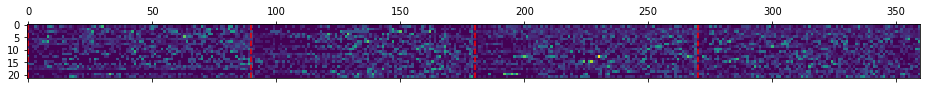

In [44]:
data_dic = {}
norm_neurons_dic = {}
session_inds_dic = {}
tasks_dic = {}
for mouse_recday in mouse_recdays:
    norm_neurons_list = []
    session_inds = []
    tasks = []
    data_dic[mouse_recday] = {}
    for session in range(12): #this is the highst plaible number of sessions
        try:
            print(f'{mouse_recday} session {session}')
            Neuron_raw=np.load(f'{Data_folder}Neuron_raw_{mouse_recday}_{session}.npy')
            print('found_neurons')
            Trial_times=np.load(f'{Data_folder}trialtimes_{mouse_recday}_{session}.npy')
            print('found_trialtimes')
            Task = np.load(f'{Data_folder}Tasks_{mouse_recday}_{session}.npy', allow_pickle=True)
            print('fount_tasks')
            
            data_dic[mouse_recday][session] = {}
            data_dic[mouse_recday][session]['Neuron_raw'] = Neuron_raw
            data_dic[mouse_recday][session]['Trial_times'] = Trial_times
            data_dic[mouse_recday][session]['Task'] = Task

            print('saved data to dictionary')
            
            num_trials=len(Trial_times)
            data_dic[mouse_recday][session]['num_trials'] = num_trials
            num_neurons=len(Neuron_raw)
            data_dic[mouse_recday][session]['num_neurons'] = num_neurons

            print('saved trials and neurons data')
            session_inds.append(session)


            ##Normalisation
            num_bins=90
            num_states=4
            num_phases=3

            Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25
            Neurons_norm=np.zeros((num_neurons,num_trials,num_bins*num_states))
            Mean_norm=np.zeros((num_neurons,num_bins*num_states))
            Neurons_norm[:]=np.nan

            Mean_norm=np.zeros((num_neurons,num_bins*num_states))
            Mean_norm[:]=np.nan

            Smoothed_norm=np.zeros((num_neurons,num_bins*num_states))
            Smoothed_norm[:]=np.nan

            Std_err_smooth=np.zeros((num_neurons,num_bins*num_states))
            Std_err_smooth[:]=np.nan
            
            print('starting normalisation')

            for neuron in np.arange(num_neurons):

                Neuron_raw_neuron=Neuron_raw[neuron,:]

                Neuron_raw_neuron_split=partition(list(Neuron_raw_neuron), list(Trial_times_conc))

                Neuron_raw_neuron_split_norm=np.asarray([normalise(Neuron_raw_neuron_split[ii])\
                                                        for ii in np.arange(len(Neuron_raw_neuron_split))])
                
                Neuron_norm=(Neuron_raw_neuron_split_norm.reshape(len(Neuron_raw_neuron_split_norm)//4,\
                                                                len(Neuron_raw_neuron_split_norm[0])*4))
                

                Neurons_norm[neuron]=Neuron_norm
                Mean_norm[neuron]=np.mean(Neuron_norm,axis=0)
                Smoothed_norm[neuron]=smooth_circ(Mean_norm[neuron])
                Std_err_smooth[neuron] = std_err(Neuron_norm)
                


        
            print('normalised_neurons')
            
            data_dic[mouse_recday][session]['Neurons_norm'] = Neurons_norm
            norm_neurons_list.append(Neurons_norm)
            data_dic[mouse_recday][session]['Neurons_mean'] = np.mean(Neurons_norm, axis=1)
            data_dic[mouse_recday][session]['Mean_norm'] = Mean_norm
            data_dic[mouse_recday][session]['Smoothed_norm'] = Smoothed_norm
            data_dic[mouse_recday][session]['Std_err_smooth'] = Std_err_smooth
            print('session done')

        except:
            print(f'{mouse_recday} session {session} does not exist')

    norm_neurons_dic[mouse_recday]=norm_neurons_list
    session_inds_dic[mouse_recday]=session_inds
    # tasks_dic[mouse_recday]=tasks
    
print('_____')
print('Example output neuron')
print('trials x normalised time bins')
print('dashed lines represent reward times')
###plotting example
neuron=0
plt.matshow(norm_neurons_dic['bp01_24032024_25032024'][0][0])
for angle in np.arange(4)*90:
    plt.axvline(angle,color='red',ls='dashed')
plt.show()

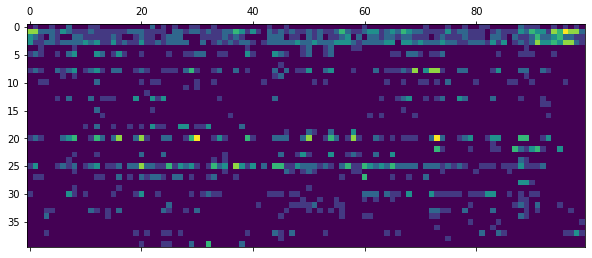

In [45]:
plt.matshow(data_dic['bp01_21032024_23032024'][1]['Neuron_raw'][:,:100])

In [46]:
data_dic.keys()

dict_keys(['bp01_24032024_25032024', 'bp01_28032024_31032024', 'bp01_21032024_23032024', 'bp01_02042024_03042024'])

# Remapping angles

In [47]:
def compute_remapping_angle(mean1, mean2):
    n_bins = len(mean1)
    angles = np.arange(n_bins) * (2 * np.pi / n_bins)  # Angles corresponding to each bin
    correlations = []
    for shift in range(n_bins):
        # Circularly shift mean1
        shifted_mean1 = np.roll(mean1, shift)
        # Compute correlation
        correlation = np.corrcoef(shifted_mean1, mean2)[0, 1]
        correlations.append(correlation)
    # Find the shift that maximizes the correlation
    best_shift = np.argmax(correlations)
    best_angle = angles[best_shift]
    return best_angle


In [48]:
remapping_angles = []

for mouse_recday in mouse_recdays:
    print(f'Processing {mouse_recday}')
    for i, session1 in enumerate(list(data_dic[mouse_recday].keys())[:-1]):
        Task1 = data_dic[mouse_recday][session1]['Task']
        print(f'Processing session {session1} with task {Task1}')
        if data_dic[mouse_recday][session1]['num_trials'] < 2:
            print('not enough trials for task 1, skipping')
            continue
        if 'defaultdict' in str(Task1):
            print('no task for task 1, skipping)')
            continue
        for j, session2 in enumerate(list(data_dic[mouse_recday].keys())[i+1:]):
            Task2 = data_dic[mouse_recday][session2]['Task']
            if data_dic[mouse_recday][session2]['num_trials'] < 2:
                print('not enough trials for task 2, skipping')
                continue
            if 'defaultdict' in str(Task2):
                print('no task for task 2, skipping)')
                continue
            if not np.array_equal(Task1, Task2):
                print('valid task pair, proceeding')
                mean1 = data_dic[mouse_recday][session1]['Smoothed_norm']
                mean2 = data_dic[mouse_recday][session2]['Smoothed_norm']

                # Normalize the mean firing rates (subtract the mean)
                if np.array_equal(mean1.shape, mean2.shape):
                    print('neuron arrays compatible, computing remapping angle')
                    for neuron in range(data_dic[mouse_recday][session1]['num_neurons']):
                        mean1x = mean1[neuron] - np.mean(mean1[neuron])
                        mean2x = mean2[neuron] - np.mean(mean2[neuron])
                        # Compute the remapping angle
                        angle = compute_remapping_angle(mean1x, mean2x)
                        remapping_angles.append(angle)



Processing bp01_24032024_25032024
Processing session 0 with task [1 5 3 9]
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
no task for task 2, skipping)
Processing session 1 with task [3 4 6 7]
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
no task for task 2, skipping)
Processing session 2 with task [5 1 9 2]
valid task pair, proceeding
neuron arrays compatible, computing

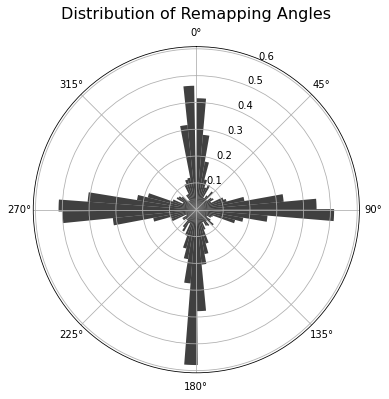

In [49]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(remapping_angles, bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


In [50]:
plot = False
# Function to compute entropy
def compute_entropy(distribution):
    probabilities = distribution / np.sum(distribution)  # Normalize to probabilities
    return entropy(probabilities)

# Function to perform permutation test and return null distribution
def permutation_test_with_visualization(original_entropy, session_data_whole, n_permutations=1000):
    permuted_entropies = []
    num_trials = session_data_whole.shape[0]
    num_bins = session_data_whole.shape[1]
    session_data_whole = session_data_whole.flatten()
    for _ in range(n_permutations):
        shift = np.random.randint(0,len(session_data_whole)-1)

        shuffled_firing_rate = np.roll(session_data_whole, shift)
        shuffled_firing_rate = np.mean(shuffled_firing_rate.reshape(num_trials, num_bins), axis=0)
        shuffled_firing_rate = shuffled_firing_rate/max(shuffled_firing_rate)
        # Divide shuffled firing rate into 4 bins and compute average for each
        shuffled_binned = [
            np.mean(shuffled_firing_rate[i:i + 90])
            for i in range(0, len(shuffled_firing_rate), 90)
        ]
        permuted_entropies.append(compute_entropy(shuffled_binned))
    # Return null distribution
    return permuted_entropies

# Parameters for permutation test
n_permutations = 100
significance_threshold = 0.05
n_timepoints = 360
# Analyze each neuron


binned_frs = {}
sig_neurons_dic = {}

for mouse_recday in mouse_recdays:
    sessions = list(data_dic[mouse_recday].keys())
    num_neurons  = data_dic[mouse_recday][sessions[0]]['num_neurons']
    binned_frs[mouse_recday] = {}
    significant_neurons = []  # Store indices of neurons that pass the test
    results = []  # Store data for visualization
    entropies = []

    for neuron_idx in range(num_neurons):
        binned_frs[mouse_recday][neuron_idx] = {}
        for session in sessions:
            if data_dic[mouse_recday][session]['num_trials'] < 2:
                print('not enough trials for task 1, skipping')
                continue
            if 'defaultdict' in str(data_dic[mouse_recday][session]['Task']):
                print('no task for task 1, skipping)')
                continue
            session_data_whole = data_dic[mouse_recday][session]['Neurons_norm'][neuron_idx] 

            norm_firing_rate = data_dic[mouse_recday][session]['Neurons_mean'][neuron_idx] 


            # Step 3: Divide into 4 bins and compute average for each bin
            binned_firing_rate = [
                np.mean(norm_firing_rate[i:i + 90])
                for i in range(0, len(norm_firing_rate), 90)
            ]

            binned_frs[mouse_recday][neuron_idx][session] = binned_firing_rate
            print(binned_firing_rate)
            # Step 4: Calculate entropy of the binned distribution
            neuron_entropy = compute_entropy(binned_firing_rate)
            entropies.append(neuron_entropy)
            print(neuron_entropy)
            print('_____________')
            # Step 5: Perform permutation test
            null_entropies = permutation_test_with_visualization(
                neuron_entropy, session_data_whole, n_permutations
            )
            # Calculate p-value
            p_value = np.mean(neuron_entropy > np.array(null_entropies))
            threshold_entropy = 1.35 # np.percentile(null_entropies, 5)  # 5th percentile

            significant = neuron_entropy < threshold_entropy  # Check for significance < threshold_entropy  # Check for significance
            # Step 6: Check significance
            if significant:
                significant_neurons.append(neuron_idx)
                results.append({
                    "session_idx": session,
                    "neuron_idx": neuron_idx,
                    "mean_firing_rate": norm_firing_rate,
                    "angles": np.linspace(0, 2 * np.pi, num=n_timepoints, endpoint=False),
                    "entropy": neuron_entropy,
                    "null_entropies": null_entropies,
                    "threshold_entropy": threshold_entropy
                })
    sigx = list(set(significant_neurons))
    sigx.sort()
    sig_neurons_dic[mouse_recday] = sigx
    # Visualization
    for result in results:
        session_idx = result["session_idx"]
        neuron_idx = result["neuron_idx"]
        mean_firing_rate = result["mean_firing_rate"]
        angles = result["angles"]
        entropy_val = result["entropy"]
        null_entropies = np.array(result["null_entropies"])  # Convert to NumPy array for processing
        threshold_entropy = result["threshold_entropy"]

        fr_data = data_dic[mouse_recday][session_idx]['Neurons_mean'][neuron_idx]
        std_err_neuron = data_dic[mouse_recday][session_idx]['Std_err_smooth'][neuron_idx]
                # Compute the mean firing rate across trials
     
        mean_firing_rates = data_dic[mouse_recday][session_idx]['Smoothed_norm'][neuron_idx]
        # Filter invalid values from null_entropies
        valid_null_entropies = null_entropies[np.isfinite(null_entropies)]

        # Plotting
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Plot 1: Polar line plot of mean firing rate
            ax1 = fig.add_subplot(121, projection="polar")
            ax1.plot(angles, mean_firing_rates, label=f"Neuron {neuron_idx} (Session {session_idx})")
            ax1.set_title("Polar Line Plot", fontsize=14)
            ax1.set_theta_zero_location("N")
            ax1.set_theta_direction(-1)

            # Plot 2: Null distribution of entropy
            ax2 = fig.add_subplot(122)
            if valid_null_entropies.size > 0:  # Check if there are valid values
                ax2.hist(valid_null_entropies, bins=30, alpha=0.7, color="grey", label="Null Distribution")
                ax2.axvline(entropy_val, color="red", linestyle="--", linewidth=2, label="Actual Entropy")
                ax2.axvline(threshold_entropy, color="green", linestyle="--", linewidth=2, label="Threshold")
                ax2.set_title("Null Distribution of Entropy", fontsize=14)
                ax2.set_xlabel("Entropy")
                ax2.set_ylabel("Frequency")
                ax2.legend()
            else:
                ax2.text(0.5, 0.5, "No valid null entropies", fontsize=14, ha='center')
            plt.suptitle(f"Neuron {neuron_idx+1} (Session {session_idx}: {binned_frs[mouse_recday][neuron_idx][session_idx]}", fontsize=16)
            plt.tight_layout()
            plt.show()


[0.4189694442795218, 0.4359084896584897, 0.4465785281036295, 0.4626455180621848]
1.385644147578624
_____________
[0.5181089947089946, 0.531647619047619, 0.5469656398831838, 0.5520301921650238]
1.385985721832594
_____________
[0.47820242782102756, 0.4771846363513031, 0.5370227774305315, 0.5048365779707421]
1.3851075707585003
_____________
[0.3887069457412595, 0.3654442888266417, 0.343157614897811, 0.39766850204133947]
1.3846719106242846
_____________
[0.5006484606517918, 0.49838062514736065, 0.4801526251526251, 0.5406715381382573]
1.3853462078814818
_____________
[0.40527475504487, 0.4331964074819562, 0.4636935650741248, 0.3660685550082101]
1.3825514528085328
_____________
no task for task 1, skipping)
[1.4608342783922417, 1.5968945406445405, 1.5457455395817468, 1.549351528101528]
1.3857834212326339
_____________
[2.0354026455026455, 2.029826455026455, 2.089466980128383, 2.037197586862515]
1.3862253620364404
_____________
[1.9513495129430338, 1.9378111703111702, 1.9545908145627395, 1.87

In [51]:
binned_frs[mouse_recday][0].keys()

dict_keys([0, 2, 5, 7])

In [52]:
sig_neurons_dic

{'bp01_24032024_25032024': [5,
  6,
  8,
  9,
  10,
  11,
  13,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  27,
  28,
  29,
  30,
  31,
  33,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  43,
  44,
  45],
 'bp01_28032024_31032024': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 'bp01_21032024_23032024': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 'bp01_02042024_03042024': [4,
  6,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  24,
  25,
  29,
  31,
  32,
  34,
  36]}

no task, skipping)
[0, 1, 2, 4, 5, 6]
0 1
[-1.06508289 -0.21168696 -0.14886349  1.42563334]
0 2
[ 1.08950188 -1.4823325   1.06811824 -0.67528762]
0 4
[ 1.12860066 -2.31733699  1.49671655 -0.30798022]
0 5
[-0.38202705 -3.09195271  1.46297864  2.01100113]
0 6
[ 0.29574511 -1.28841921 -0.85546683  1.84814093]
1 2
[ 2.15458477 -1.27064554  1.21698172 -2.10092095]
1 4
[ 2.19368355 -2.10565003  1.64558004 -1.73361355]
1 5
[ 0.68305583 -2.88026575  1.61184213  0.58536779]
1 6
[ 1.360828   -1.07673225 -0.70660335  0.4225076 ]
2 4
[ 0.03909877 -0.83500449  0.42859831  0.3673074 ]
2 5
[-1.47152894 -1.60962021  0.3948604   2.68628874]
2 6
[-0.79375677  0.19391329 -1.92358507  2.52342855]
4 5
[-1.51062771 -0.77461572 -0.03373791  2.31898134]
4 6
[-0.83285555  1.02891778 -2.35218338  2.15612115]
5 6
[ 0.67777216  1.8035335  -2.31844547 -0.16286019]
0 1
[ 0.04766035  2.24585592 -0.77907238 -1.51444389]
0 2
[ 0.59143796 -0.33635869 -1.12827364  0.87319436]
0 4
[-1.71876861  2.40960656 -1.3432229   0.

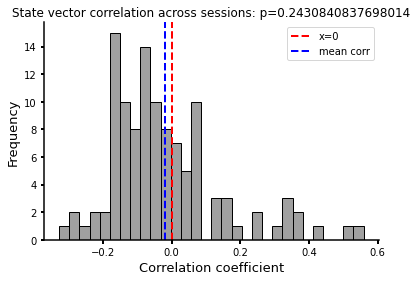

In [53]:

valid_sessions_dic = {}
all_neuron_correlations=[]
for mouse_recday in mouse_recdays:
    valid_sessions = []
    tasks = []
    for session in list(data_dic[mouse_recday].keys()):
        if data_dic[mouse_recday][session]['num_trials'] < 2:
            print('not enough trials for task 1, skipping')
            continue
        if 'defaultdict' in str(data_dic[mouse_recday][session]['Task']):
            print('no task, skipping)')
            continue
        if not any(np.array_equal(data_dic[mouse_recday][session]['Task'], candidate) for candidate in tasks):
            tasks.append(data_dic[mouse_recday][session]['Task'])
            valid_sessions.append(session)
    # data_dic[mouse_recday]['valid_sessions'] = valid_sessions
    sig_neurons = sig_neurons_dic[mouse_recday]
    print(valid_sessions)
    valid_sessions_dic[mouse_recday] = valid_sessions
    for neuron_idx in sig_neurons:
            corrs = []
            for i, session1_idx in enumerate(valid_sessions[:-1]):
                for session2_idx in valid_sessions[i+1:]:
                    print(session1_idx, session2_idx)
                    binned_firing_rate1 = zscore(binned_frs[mouse_recday][neuron_idx][session1_idx])
                    
                    binned_firing_rate2 = zscore(binned_frs[mouse_recday][neuron_idx][session2_idx])
                    print(binned_firing_rate1-binned_firing_rate2)

                    correlation = np.corrcoef(binned_firing_rate1, binned_firing_rate2)[0, 1]
                    corrs.append(correlation)
        
            all_neuron_correlations.append(np.mean(corrs))

t_stat, p_value = stats.ttest_1samp(all_neuron_correlations, 0)
mean_corr = np.mean(all_neuron_correlations)
fig, ax = plt.subplots()
sns.histplot(all_neuron_correlations, kde=False, color="grey", bins=30)
sns.despine()

# Increase line thickness
plt.tick_params(axis='both', which='major', width=2)  # Increase thickness of the ticks

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=10)  # Increase 
# Add a red vertical line at x=0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='x=0')
plt.axvline(x=mean_corr, color='blue', linestyle='--', linewidth=2, label='mean corr')
plt.gca().spines['left'].set_linewidth(1.5)  # Make y-axis thicker
plt.gca().spines['bottom'].set_linewidth(1.5)  
# Add labels and legend
plt.xlabel('Correlation coefficient', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title(f'State vector correlation across sessions: p={p_value}')
plt.legend()
plt.savefig('/Users/AdamHarris/Desktop/remapping_correlations.pdf', dpi=300) 
# Show the plot
plt.show()


In [54]:
data_dic[mouse_recday].keys()

dict_keys([0, 2, 4, 5, 7, 9])

In [55]:
len(all_neuron_correlations)

113

In [56]:
from tqdm import tqdm

def compute_remapping_angle(mean1, mean2):
    n_bins = len(mean1)
    angles = np.arange(n_bins) * (2 * np.pi / n_bins)  # Angles corresponding to each bin
    correlations = []
    for shift in range(n_bins):
        # Circularly shift mean1
        shifted_mean1 = np.roll(mean1, shift)
        # Compute correlation
        correlation = np.corrcoef(shifted_mean1, mean2)[0, 1]
        correlations.append(correlation)
    # Find the shift that maximizes the correlation
    best_shift = np.argmax(correlations)
    best_angle = angles[best_shift]
    return best_shift
    
pair_angles_dic = {}
angle_shifts = []
angle_1s = []
angle_2s = []
for mouse_recday in tqdm(mouse_recdays):
    pair_angles = defaultdict(list)
    sig_neurons = sig_neurons_dic[mouse_recday]
    valid_sessions = valid_sessions_dic[mouse_recday]
    for ind, session1_idx in enumerate(valid_sessions[:-1]):
        for session2_idx in valid_sessions[ind+1:]:
            for i, n1 in enumerate(sig_neurons[:-1]):
                for j, n2 in enumerate(sig_neurons[i+1:]):
                    if n1!=n2:
                        # Get firing rates for these two neurons in session X
                        mean1 = data_dic[mouse_recday][session1_idx]['Smoothed_norm'][n1]
                        mean1 = mean1-np.mean(mean1)
                        mean2 = data_dic[mouse_recday][session1_idx]['Smoothed_norm'][n2]
                        mean2 = mean2-np.mean(mean2)
                        angle1 = compute_remapping_angle(mean1, mean2)
                        angle_1s.append(angle1)

                        mean1 = data_dic[mouse_recday][session2_idx]['Smoothed_norm'][n1]
                        mean1 = mean1-np.mean(mean1)
                        mean2 = data_dic[mouse_recday][session2_idx]['Smoothed_norm'][n2]
                        mean2 = mean2-np.mean(mean2)   
                        angle2 = compute_remapping_angle(mean1, mean2)
                        angle_2s.append(angle2)
                        # Compute the difference in their angles between sessions
                        angle_diff = (angle1 - angle2) % 360
                        # angle_diff = (angle_diff + 180) % 360 - 180
                
                        pair_key = (n1, n2)
                        pair_angles[pair_key].append(angle_diff)
                        angle_shifts.append(angle_diff)
    pair_angles_dic[mouse_recday] = pair_angles

100%|██████████| 4/4 [30:38<00:00, 459.75s/it]


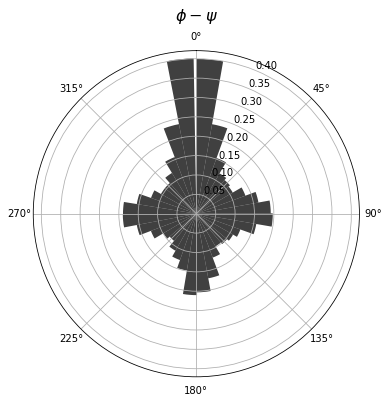

In [57]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_shifts), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

In [60]:
rolled_mean1 = np.roll(mean1, 87)
compute_remapping_angle(mean1, rolled_mean1)

87

# changed above from mean norm to smoothed norm to see what effect that has

{'bp01_24032024_25032024': {0: {'Neuron_raw': array([[1., 0., 0., ..., 0., 0., 2.],
          [3., 4., 1., ..., 3., 5., 4.],
          [2., 2., 0., ..., 1., 1., 0.],
          ...,
          [0., 1., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [1., 1., 0., ..., 0., 0., 1.]]),
   'Trial_times': array([[      0,    8842,   27812,   58836,   77075],
          [  77075,   88435,   93950,  106243,  122066],
          [ 122066,  132313,  137613,  171892,  200913],
          [ 200913,  212667,  215313,  255516,  285560],
          [ 285560,  294378,  306949,  370613,  389572],
          [ 389572,  393468,  409624,  418751,  451698],
          [ 451698,  548743,  556248,  569698,  575978],
          [ 575978,  585858,  593137,  603802,  609369],
          [ 609369,  638579,  642854,  650239,  658905],
          [ 658905,  663729,  675392,  682282,  701539],
          [ 701539,  705952,  711043,  722571,  727036],
          [ 727036,  738784,  744115,  759943,  7701

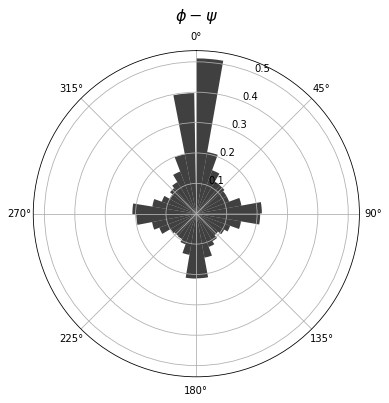

In [29]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_shifts), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

In [106]:
data_session

array([], shape=(0, 360), dtype=float64)

[[0.36745394 0.36396323 0.36098917 ... 0.38066359 0.3758455  0.37142828]
 [1.51483824 1.5165175  1.51780296 ... 1.50841472 1.51067767 1.51285625]
 [0.53627547 0.53602633 0.53546073 ... 0.53525745 0.53586834 0.53621776]
 ...
 [0.06758986 0.06762886 0.06778419 ... 0.06799137 0.06779155 0.06765042]
 [0.24555622 0.24577742 0.24575307 ... 0.24345575 0.24438592 0.24509071]
 [0.38818439 0.38270421 0.37797374 ... 0.40787919 0.40090157 0.39429234]]


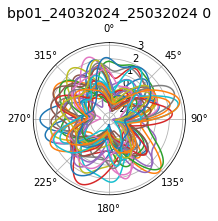

[[0.44417605 0.44232088 0.44096703 ... 0.45256826 0.44932582 0.44651992]
 [2.02455736 2.03438391 2.04388888 ... 1.99513799 2.00472429 2.01460025]
 [1.57167643 1.57007861 1.5681621  ... 1.57475502 1.57398013 1.57296646]
 ...
 [0.05413198 0.05454046 0.05491957 ... 0.05263932 0.05318865 0.053684  ]
 [0.16219824 0.1605638  0.15897738 ... 0.1672516  0.16555713 0.16386791]
 [0.45381605 0.44871313 0.44435525 ... 0.47236998 0.46578094 0.45954788]]


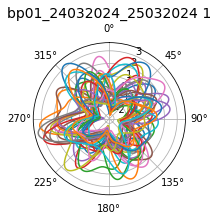

[[0.42174537 0.4153993  0.40992151 ... 0.44475855 0.43655907 0.42884375]
 [1.90876952 1.91593385 1.92337866 ... 1.89009551 1.89574001 1.9020007 ]
 [1.64826119 1.64597908 1.64319569 ... 1.6524554  1.65145083 1.65006998]
 ...
 [0.03012356 0.02999818 0.03011519 ... 0.03192018 0.03109256 0.03049062]
 [0.17368592 0.1730841  0.17226679 ... 0.1741198  0.17420412 0.17406059]
 [0.25331114 0.25008769 0.2472016  ... 0.26414098 0.26042825 0.25678854]]


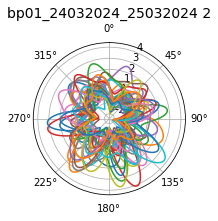

[[0.35075854 0.34410743 0.33779329 ... 0.37156564 0.36460875 0.35763269]
 [1.31534268 1.31675664 1.31761615 ... 1.30788218 1.31088584 1.31338148]
 [1.46354778 1.46130074 1.45794496 ... 1.46347201 1.46461808 1.46465427]
 ...
 [0.10081453 0.10128575 0.10184194 ... 0.09982218 0.10009183 0.10041973]
 [0.20502906 0.2034599  0.20177907 ... 0.20913014 0.20785737 0.20649196]
 [0.66631349 0.65084016 0.63671764 ... 0.71804714 0.70020751 0.68286305]]


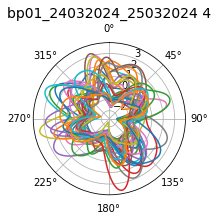

[[0.49016833 0.49029113 0.49090386 ... 0.49236594 0.49125484 0.49050393]
 [1.69185967 1.69144332 1.69041229 ... 1.68922984 1.69075201 1.69163391]
 [1.41003641 1.41258162 1.41416485 ... 1.39730539 1.40229466 1.40657763]
 ...
 [0.07860659 0.07943096 0.08044157 ... 0.07724791 0.07751884 0.07796992]
 [0.21249491 0.21079512 0.20910939 ... 0.21725807 0.2157647  0.21416504]
 [0.72981521 0.72642206 0.723524   ... 0.74220685 0.73779889 0.73363777]]


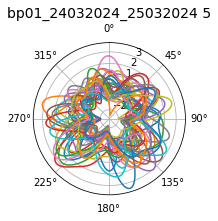

[[0.32568356 0.32146166 0.31742917 ... 0.33901651 0.33449785 0.33004238]
 [0.87164103 0.87779666 0.88314659 ... 0.84912105 0.85720251 0.86474356]
 [0.23760537 0.23836537 0.23873603 ... 0.23299693 0.23490976 0.23645107]
 ...
 [0.06167043 0.06265177 0.06367845 ... 0.05903251 0.05985871 0.06073765]
 [0.22108967 0.22618002 0.23106267 ... 0.20504742 0.21047516 0.21583911]
 [0.14255112 0.14143927 0.14042617 ... 0.14662085 0.14512563 0.14377476]]


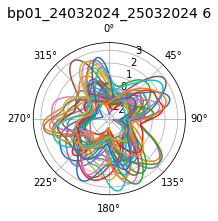

[[0.50046186 0.50148752 0.50272374 ... 0.49876887 0.49909715 0.4996611 ]
 [1.42058032 1.42552136 1.43075201 ... 1.40796129 1.41176716 1.41598189]
 [0.09758921 0.0980344  0.09851217 ... 0.09650871 0.09682412 0.09718587]
 ...
 [0.12320796 0.12205907 0.12095463 ... 0.12668877 0.12554842 0.12437981]
 [0.23159467 0.23252521 0.23327619 ... 0.22804461 0.22932205 0.2305167 ]
 [0.35867519 0.35984364 0.3608286  ... 0.35450854 0.35595927 0.35736519]]


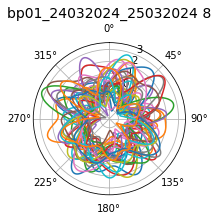

[[0.34671467 0.34381095 0.34084671 ... 0.35455262 0.35213508 0.34950692]
 [0.1731964  0.17179221 0.17038401 ... 0.17709921 0.17587524 0.17456772]
 [1.55225233 1.5602458  1.56768141 ... 1.52610276 1.53505005 1.5438133 ]
 ...
 [0.00533484 0.00510805 0.00492946 ... 0.00630549 0.00593415 0.00560992]
 [0.01832599 0.01789879 0.0176718  ... 0.02057639 0.0196891  0.01893096]
 [1.80193371 1.79428043 1.78569299 ... 1.81757262 1.81368694 1.8084471 ]]


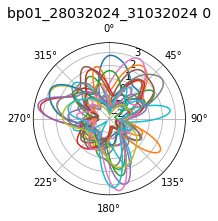

[[0.18769876 0.18141219 0.17539728 ... 0.20749498 0.20081127 0.19418908]
 [1.72006741 1.72408729 1.72658668 ... 1.69961451 1.70771502 1.71457998]
 [1.28258045 1.28863329 1.29419707 ... 1.26189939 1.26914606 1.27606788]
 ...
 [0.02134921 0.02165758 0.02191548 ... 0.02012744 0.02058196 0.02099012]
 [0.0092119  0.00878958 0.00839255 ... 0.01055539 0.01010325 0.00965248]
 [1.30800298 1.30206549 1.29512946 ... 1.31878316 1.31642589 1.31281938]]


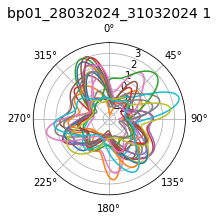

[[0.23409519 0.22895053 0.22374341 ... 0.24853539 0.24394196 0.23911169]
 [1.62673038 1.63473131 1.641028   ... 1.59346629 1.6059554  1.61709921]
 [0.89259533 0.90176608 0.91069089 ... 0.86450752 0.87386554 0.88326352]
 ...
 [0.05988229 0.05624452 0.05271442 ... 0.07107935 0.06733636 0.06359213]
 [0.01893126 0.01921887 0.01959474 ... 0.01856586 0.01860835 0.01872873]
 [1.2346203  1.23004827 1.22435893 ... 1.24050832 1.23992164 1.23794342]]


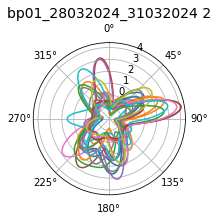

[[0.182363   0.18101474 0.17981659 ... 0.1872875  0.18550386 0.18386072]
 [1.73937189 1.73422223 1.7288833  ... 1.7539547  1.74919789 1.74435565]
 [1.33163067 1.33518164 1.33828993 ... 1.31923995 1.3235557  1.32772403]
 ...
 [0.00868333 0.00877296 0.00896859 ... 0.00904014 0.00881938 0.00869909]
 [0.02348046 0.02476503 0.02627894 ... 0.02107321 0.02163126 0.02243397]
 [1.10531128 1.10055969 1.0953996  ... 1.11657741 1.11334947 1.10958936]]


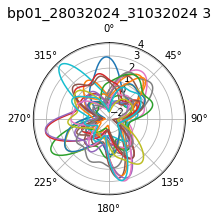

[[0.14428521 0.14263976 0.14097971 ... 0.14910679 0.14751688 0.14591077]
 [0.41204321 0.41550663 0.41871029 ... 0.40081461 0.4046139  0.40838398]
 [1.8318516  1.84684969 1.86107383 ... 1.78474073 1.80052178 1.81631746]
 ...
 [0.01083661 0.01000095 0.00919742 ... 0.01345447 0.01257234 0.01169708]
 [0.01217922 0.01251948 0.01294564 ... 0.01169049 0.01176477 0.01192747]
 [1.0895464  1.08440122 1.07877967 ... 1.10129212 1.09804638 1.09411771]]


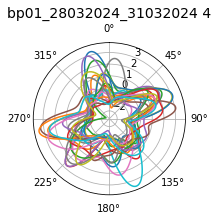

[[0.24954164 0.24923854 0.2490229  ... 0.25068459 0.25029255 0.2499028 ]
 [1.19943472 1.21233758 1.22442316 ... 1.15696293 1.17160835 1.18581474]
 [1.92442571 1.94741327 1.96999683 ... 1.85492068 1.87796867 1.9012073 ]
 ...
 [0.00754509 0.00791685 0.00832321 ... 0.0066867  0.00692483 0.00721243]
 [0.04615712 0.04740136 0.04878069 ... 0.04317634 0.04405132 0.04504206]
 [1.48677732 1.49313719 1.49951373 ... 1.46772063 1.47406239 1.48042039]]


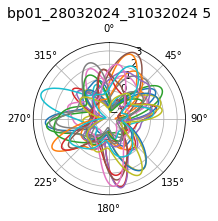

[[0.2881985  0.27984003 0.27186818 ... 0.31459059 0.30567752 0.29684575]
 [1.07089323 1.06995472 1.06863628 ... 1.07140973 1.0716102  1.0714425 ]
 [1.52742353 1.53286181 1.53839073 ... 1.51230068 1.51707637 1.52213909]
 ...
 [0.01466931 0.013304   0.01204437 ... 0.01928561 0.01767438 0.01613036]
 [0.02954843 0.02820381 0.02705704 ... 0.0346735  0.03279757 0.03108384]
 [1.2617218  1.2513344  1.24092918 ... 1.2909552  1.28169826 1.27190101]]


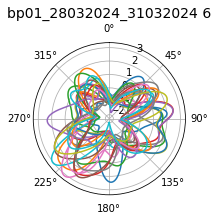

[[0.31652833 0.30982495 0.30336428 ... 0.33716294 0.33028416 0.32337844]
 [1.50046441 1.49587225 1.49092678 ... 1.5117992  1.50843193 1.50465701]
 [1.87925415 1.88700662 1.89500863 ... 1.85856982 1.86492051 1.8718559 ]
 ...
 [0.01473468 0.01395708 0.01324977 ... 0.01739113 0.01646213 0.01557284]
 [0.02667913 0.02759491 0.02853153 ... 0.0241335  0.02494087 0.02579171]
 [1.477169   1.46495374 1.45286718 ... 1.51305979 1.50135054 1.48935039]]


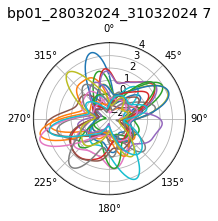

[[0.255326   0.25333331 0.25135587 ... 0.2610039  0.25919614 0.2572926 ]
 [2.095556   2.10552462 2.11499123 ... 2.0641976  2.07472339 2.08523754]
 [1.31753253 1.3191714  1.32036518 ... 1.31013975 1.31298268 1.31546062]
 ...
 [0.06858839 0.06761963 0.06655922 ... 0.07094167 0.0702491  0.06946498]
 [0.00516798 0.0049555  0.00481844 ... 0.00622827 0.00580824 0.00545323]
 [0.00565091 0.00576571 0.00595302 ... 0.00572705 0.00563335 0.00560709]]


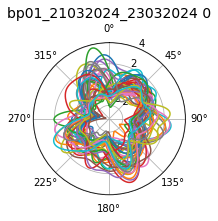

[[0.35443156 0.35444118 0.35437934 ... 0.35389605 0.35416285 0.35434129]
 [1.86517696 1.86944009 1.87365507 ... 1.8528336  1.85679402 1.8609376 ]
 [1.44707551 1.441987   1.43691302 ... 1.46185628 1.4570597  1.45211951]
 ...
 [0.12156275 0.11475055 0.10816663 ... 0.142212   0.13541267 0.1284904 ]
 [0.00592971 0.0057237  0.00552643 ... 0.00657783 0.00635904 0.0061422 ]
 [0.09971357 0.09370961 0.08759496 ... 0.11598494 0.110959   0.10549945]]


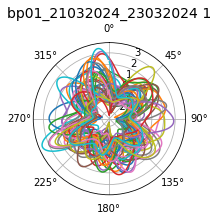

[[0.20599245 0.2036173  0.20122962 ... 0.21255525 0.21050288 0.20830348]
 [1.82944893 1.82885416 1.82810376 ... 1.83004314 1.83006098 1.82985917]
 [1.09204321 1.08908798 1.08584466 ... 1.09905642 1.0970252  1.09469105]
 ...
 [0.05592076 0.05344532 0.05098006 ... 0.06301222 0.06074273 0.05836657]
 [0.01059547 0.00962035 0.00871562 ... 0.01393701 0.01275597 0.01164112]
 [0.01274495 0.01133975 0.01012651 ... 0.01805337 0.01611297 0.01433885]]


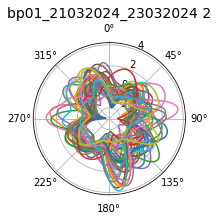

[[0.38783162 0.3845539  0.38141421 ... 0.39793946 0.39457942 0.39119294]
 [1.99995251 2.00828828 2.01595638 ... 1.97238022 1.98184027 1.99108718]
 [1.22751148 1.22638393 1.22470302 ... 1.22733134 1.22799644 1.22805708]
 ...
 [0.11276664 0.11326402 0.11344079 ... 0.10927364 0.11076921 0.11193594]
 [0.02268474 0.02170758 0.0208643  ... 0.02619474 0.0249542  0.02377536]
 [0.01011433 0.00982674 0.00960303 ... 0.01134605 0.01087796 0.01046562]]


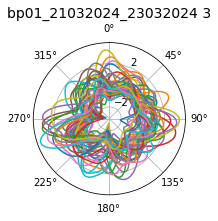

[[0.41508267 0.41106402 0.40686398 ... 0.42542517 0.42231346 0.418851  ]
 [1.77637872 1.78179949 1.78662311 ... 1.75733748 1.76404705 1.77043067]
 [2.07968775 2.07432507 2.06755881 ... 2.08749335 2.08620138 2.08363091]
 ...
 [0.17107696 0.16740402 0.16360015 ... 0.18136904 0.17805141 0.17462393]
 [0.00676044 0.00681109 0.00691356 ... 0.00691183 0.00681279 0.00676141]
 [0.0047336  0.00447723 0.00429254 ... 0.00591735 0.00545657 0.00506076]]


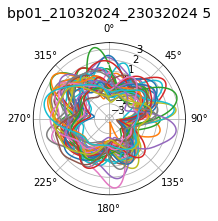

[[0.38980549 0.38837588 0.38782476 ... 0.39947581 0.39535469 0.39212916]
 [0.88953833 0.90810393 0.92616512 ... 0.8331865  0.85184524 0.87070835]
 [1.47303995 1.49847537 1.52253023 ... 1.39168937 1.41929157 1.44653147]
 ...
 [0.0666634  0.06612559 0.06543086 ... 0.06711176 0.06717644 0.067021  ]
 [0.00398486 0.00416183 0.00437487 ... 0.00360394 0.0037125  0.00383761]
 [0.00262964 0.00287131 0.00314437 ... 0.00208295 0.00223592 0.00241813]]


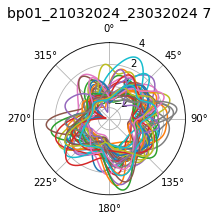

[[0.3972633  0.39453802 0.39171567 ... 0.40416472 0.40214545 0.39982309]
 [0.9479073  0.94284761 0.93741639 ... 0.9606824  0.95682835 0.95257295]
 [1.7694538  1.76387434 1.75776791 ... 1.78274644 1.77888665 1.77446332]
 ...
 [0.0979049  0.09436149 0.09095655 ... 0.10875143 0.10516213 0.10152618]
 [0.019388   0.01884155 0.01832145 ... 0.02105369 0.02051005 0.01995009]
 [0.02940189 0.03032837 0.03127745 ... 0.02705396 0.02773567 0.02852751]]


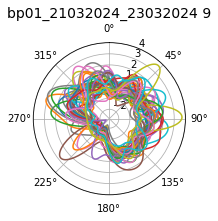

[[0.29160977 0.28794197 0.2845478  ... 0.30334366 0.29940346 0.2954606 ]
 [1.75739644 1.75617991 1.75477849 ... 1.75989291 1.75925555 1.7584226 ]
 [1.83518247 1.82025954 1.80538392 ... 1.87833853 1.86440149 1.84996115]
 ...
 [0.01820851 0.01781817 0.01749719 ... 0.0196988  0.01915885 0.01865866]
 [0.21568276 0.21466784 0.21453309 ... 0.22321413 0.22004546 0.21750466]
 [0.32130133 0.31451842 0.3081785  ... 0.34305167 0.33569214 0.32840096]]


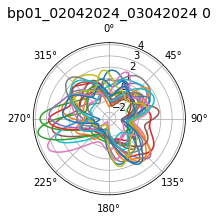

[[0.26133356 0.25228492 0.2437907  ... 0.29080594 0.28070875 0.2708445 ]
 [1.36625888 1.3642813  1.3627972  ... 1.37549073 1.37185212 1.3687739 ]
 [1.36373783 1.35378248 1.34395775 ... 1.39351565 1.38368322 1.37373241]
 ...
 [0.01821707 0.01798515 0.01781084 ... 0.01931218 0.01887548 0.01851168]
 [0.23651677 0.23144208 0.22704063 ... 0.25455789 0.24820309 0.24214536]
 [0.44956912 0.43663843 0.42435796 ... 0.49033429 0.47661842 0.46296259]]


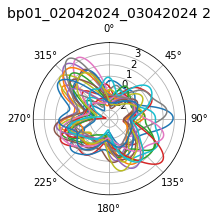

[]


IndexError: index 4 is out of bounds for axis 0 with size 0

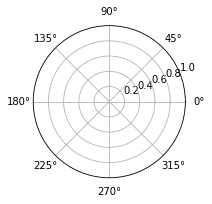

In [61]:
for mouse_recday in mouse_recdays:
    sig_neurons = sig_neurons_dic[mouse_recday]
    for session1_idx in data_dic[mouse_recday].keys():
        if isinstance(session1_idx, int):
            data_session = data_dic[mouse_recday][session1_idx]['Smoothed_norm']
                        
            ax1 = plt.subplot(121, projection="polar")
            print(data_session)
            for neuron in sig_neurons:
                n = zscore(data_session[neuron])
                ax1.plot(angles, n)

            ax1.set_title(f"{mouse_recday} {session1_idx}", fontsize=14)
            ax1.set_theta_zero_location("N")
            ax1.set_theta_direction(-1)
            plt.show()

In [114]:
sig_neurons_dic

{}

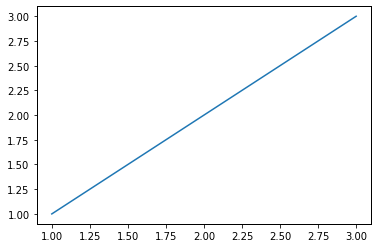

In [110]:
plt.plot([1, 2, 3], [1, 2 ,3])

<AxesSubplot:xlabel='angle between neurons', ylabel='angle shift'>

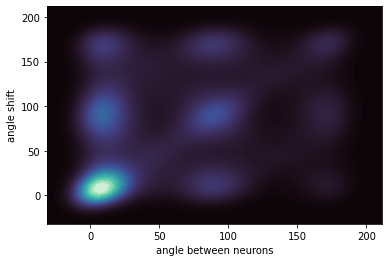

In [62]:
angle_2s_circ  =  [min(a, 360 - a) for a in angle_2s]
angle_shifts_circ =  [min(a, 360 - a) for a in angle_shifts]

angles_vs_shifts_dic = {
    'angle between neurons': angle_2s_circ,
    'angle shift': angle_shifts_circ 
}
sns.kdeplot(data = angles_vs_shifts_dic, x='angle between neurons', y='angle shift',
            fill=True, common_norm=False, cmap="mako", thresh=0, levels=100)
            


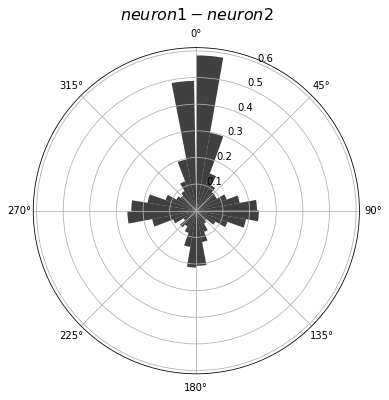

In [52]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_1s), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$neuron1 - neuron2$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

Bin counts: [7821 5216 5187 5026]
Observed Frequencies: [7821 5216 5187 5026]
Expected Frequencies: [5812 5812 5812 5812]
Chi-squared Value: 420.7799481890273
P-value: 6.978968624761742e-91


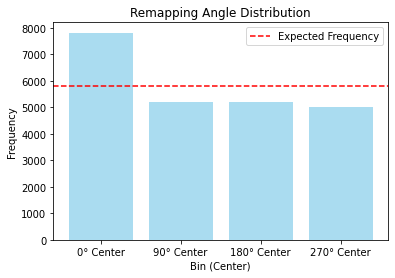

In [53]:
from scipy.stats import chi2_contingency

rotated_angles = (np.array(angle_shifts) + 45) % 360

# Step 3: Define bin edges for 4 bins: 0-90, 90-180, 180-270, 270-360
bin_edges = np.array([0, 90, 180, 270, 360])
bin_labels = ["0° Center", "90° Center", "180° Center", "270° Center"]
# Step 4: Use np.digitize to assign each rotated angle to a bin
bins = np.digitize(rotated_angles, bins=bin_edges, right=False)

# Step 5: Adjust the bin numbers (the digitize function returns bin indices starting from 1)
bins = bins - 1  # Adjust to make bin indices start from 0

# Step 6: Calculate frequencies of remapping angles in each bin
observed_frequencies = np.bincount(bins, minlength=4)

# Output the results
print("Bin counts:", observed_frequencies)

# Step 6: Expected frequencies (uniform distribution)
expected_frequencies = np.full_like(observed_frequencies, len(rotated_angles) / 4)

# Step 7: Perform chi-squared test
chi2, p_value = chi2_contingency([observed_frequencies, expected_frequencies])[:2]

# Step 8: Print results
print(f"Observed Frequencies: {observed_frequencies}")
print(f"Expected Frequencies: {expected_frequencies}")
print(f"Chi-squared Value: {chi2}")
print(f"P-value: {p_value}")



plt.bar(bin_labels, observed_frequencies, color="skyblue", alpha=0.7)
plt.axhline(y=expected_frequencies[0], color="red", linestyle="--", label="Expected Frequency")
plt.xlabel("Bin (Center)")
plt.ylabel("Frequency")
plt.title("Remapping Angle Distribution")
plt.legend()
plt.show()


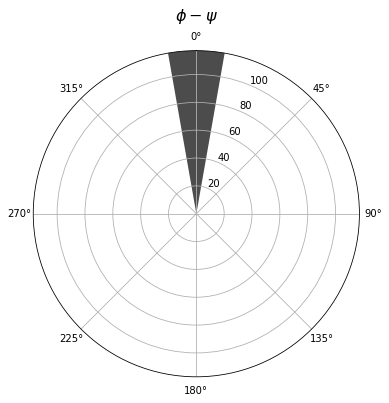

In [147]:
def sum_list_of_arrays(list_of_arrays):
    """
    Sum a list of arrays, each of length n, to return another array of length n.
    
    Parameters
    ----------
    list_of_arrays : list of numpy arrays
        A list where each element is a NumPy array of equal length.
        
    Returns
    -------
    numpy.ndarray
        A single NumPy array that is the element-wise sum of all the arrays in the input list.
    """
    
    # Convert the list of arrays into a 2D array (matrix) where each array is a row
    # For example, if list_of_arrays = [array([1,2,3]), array([4,5,6])]
    # stacking them gives a matrix of shape (m, n), where m is the number of arrays.
    stacked = np.vstack(list_of_arrays)
    
    # Now sum along the first axis (rows), producing a single array
    summed_array = np.sum(stacked, axis=0)
    return summed_array


average_hists = []

for mouse_recday in mouse_recdays:
    pair_angles = pair_angles_dic[mouse_recday]
    histograms = []
    example_pair = list(pair_angles.keys())[0]

    n_session_pairs = len(pair_angles[example_pair])
    session_pair_angle_diffs = [[] for _ in range(n_session_pairs)]

    for (n1, n2), angles_list in pair_angles.items():
        for k, angle in enumerate(angles_list):
            session_pair_angle_diffs[k].append(angle)

    bins = np.linspace(0, 360, 37)

    for angle_list in session_pair_angle_diffs:
        counts, _ = np.histogram(angle_list, bins=bins)
        histograms.append(counts)

    histograms_array = np.array(histograms)  # shape: (n_session_pairs, number_of_bins-1)
    average_hist = np.mean(histograms_array, axis=0)
    average_hists.append(average_hist)

sum_hists = sum_list_of_arrays(average_hists)

bin_centers_degrees = 0.5 * (bins[:-1] + bins[1:])
bin_centers_radians = np.deg2rad(bin_centers_degrees)

# The width of each bin in radians
bin_width = np.deg2rad(bins[1] - bins[0])

# Create a polar subplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,6))

# Plot using a bar plot in polar coordinates
# theta is bin_centers_radians, height is sum_hists
bars = ax.bar(bin_centers_radians, sum_hists, width=bin_width, bottom=0.0, alpha=0.7, color='black', edgecolor='none')

# Customize the plot
ax.set_theta_zero_location("N")  # Set 0 degrees at the top (North)
ax.set_theta_direction(-1)       # Plot clockwise
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
# Optional: adjust radial limits or add gridlines
ax.set_rlim(0, max(average_hist)*1.1)

plt.show()

Processing bp01_24032024_25032024
Processing session 0 with task [1 5 3 9]
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
no task for task 2, skipping)
Processing session 1 with task [3 4 6 7]
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
valid task pair, proceeding
neuron arrays compatible, computing remapping angle
no task for task 2, skipping)
Processing session 2 with task [5 1 9 2]
valid task pair, proceeding
neuron arrays compatible, computing

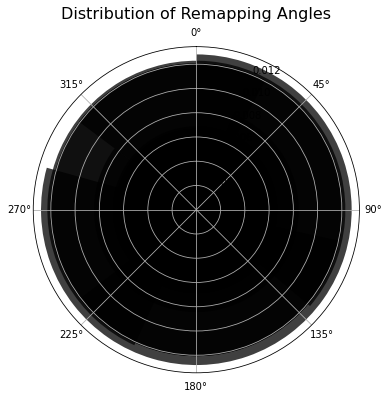

In [ ]:
remapping_angles = []

for mouse_recday in mouse_recdays:
    print(f'Processing {mouse_recday}')
    for i, session1 in enumerate(list(data_dic[mouse_recday].keys())[:-1]):
        if not isinstance(session1, str):
            Task1 = data_dic[mouse_recday][session1]['Task']
            print(f'Processing session {session1} with task {Task1}')
            if data_dic[mouse_recday][session1]['num_trials'] < 2:
                print('not enough trials for task 1, skipping')
                continue
            if 'defaultdict' in str(Task1):
                print('no task for task 1, skipping)')
                continue
            for j, session2 in enumerate(list(data_dic[mouse_recday].keys())[i+1:]):
                if not isinstance(session2, str):
                    Task2 = data_dic[mouse_recday][session2]['Task']
                    if data_dic[mouse_recday][session2]['num_trials'] < 2:
                        print('not enough trials for task 2, skipping')
                        continue
                    if 'defaultdict' in str(Task2):
                        print('no task for task 2, skipping)')
                        continue
                    if not np.array_equal(Task1, Task2):
                        print('valid task pair, proceeding')
                        mean1 = data_dic[mouse_recday][session1]['Mean_norm']
                        mean2 = data_dic[mouse_recday][session2]['Mean_norm']

                        # Normalize the mean firing rates (subtract the mean)
                        if np.array_equal(mean1.shape, mean2.shape):
                            print('neuron arrays compatible, computing remapping angle')
                            for neuron in sig_neurons_dic[mouse_recday]:
                                mean1x = mean1[neuron] - np.mean(mean1[neuron])
                                mean2x = mean2[neuron] - np.mean(mean2[neuron])
                                # Compute the remapping angle
                                angle = compute_remapping_angle(mean1x, mean2x)
                                remapping_angles.append(angle)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(npremapping_angles, bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()



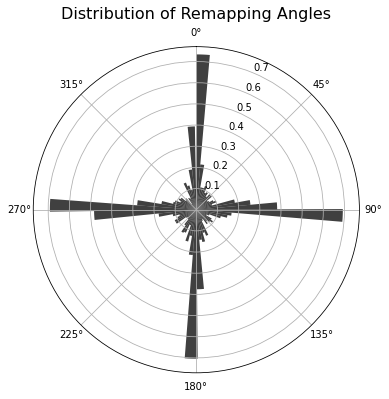

In [167]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(remapping_angles), bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


dict_keys([0, 1, 2, 4, 5, 6, 8, 'valid_sessions'])

In [206]:
all_neurons_concat = []
for mouse_recday in mouse_recdays:
    for session in valid_sessions_dic[mouse_recday]:
        sig_neurons = sig_neurons_dic[mouse_recday]
        xxx = data_dic[mouse_recday][session]['Mean_norm']
        all_neurons_concat.append(xxx[sig_neurons,:])
all_neurons_concat = np.vstack((all_neurons_concat))


In [190]:
len(all_neurons_concat)

22

In [192]:
all_neurons_concat.shape

(636, 360)

In [193]:
from mpl_toolkits.mplot3d import Axes3D  # Just to be explicit, though in newer Matplotlib versions not always needed
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

UMAP embedding shape: (360, 3)


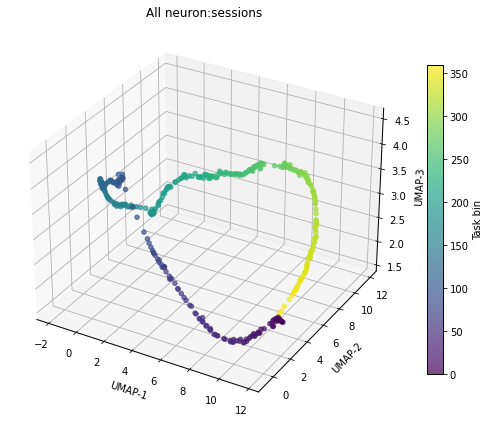

In [232]:
# -------------------------
# Preprocessing (Optional)
# -------------------------
# Standard scaling the data so that each feature (neuron) has zero mean and unit variance.


all_neurons_concat = []
for mouse_recday in mouse_recdays:
    for session in valid_sessions_dic[mouse_recday]:
        sig_neurons = sig_neurons_dic[mouse_recday]
        xxx = data_dic[mouse_recday][session]['Mean_norm']
        all_neurons_concat.append(xxx[sig_neurons,:])
all_neurons_concat = np.vstack((all_neurons_concat))


labels = list(range(360))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

# -------------------------
# UMAP Dimensionality Reduction
# -------------------------
# We set n_components=3 to get a 3D embedding.

#MY PARAMS
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_embedding = reducer.fit_transform(X_scaled)


# YOUR PARAMS (plus random state for reproducability)
# reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
# X_embedding = reducer.fit_transform(X_scaled)




# X_embedding will now be of shape (n_samples, 3)
print("UMAP embedding shape:", X_embedding.shape)

# -------------------------
# Visualization
# -------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: we color points by their condition/label
scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                     c=labels, cmap='viridis', alpha=0.7)

ax.set_title('All neuron:sessions')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')

# Optionally add a legend or colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
cbar.set_label('Task bin')

plt.tight_layout()
plt.show()

UMAP embedding shape: (360, 3)


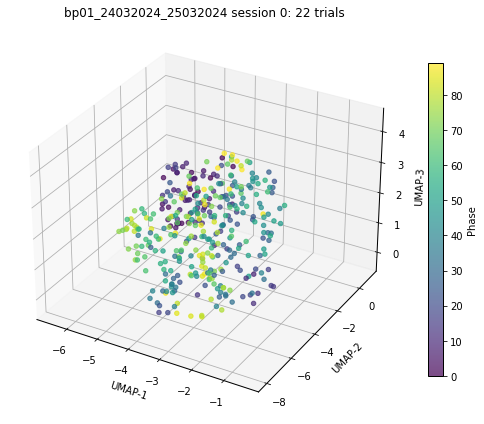

UMAP embedding shape: (360, 3)


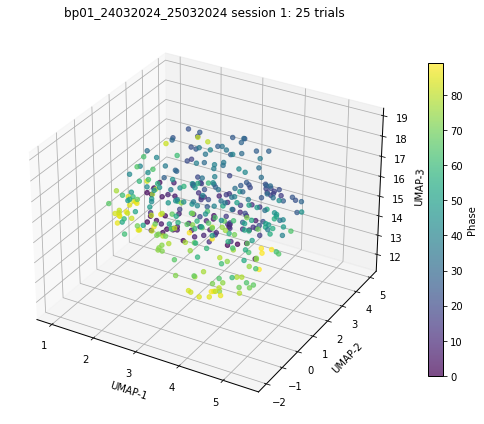

UMAP embedding shape: (360, 3)


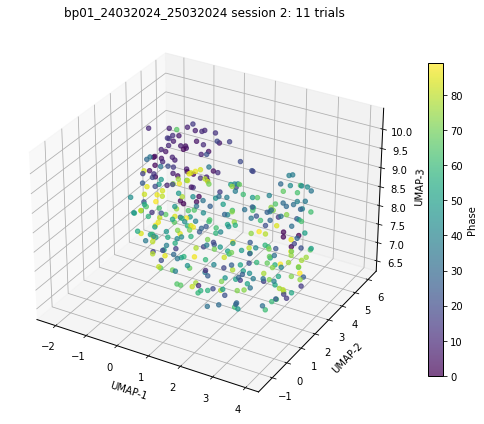

UMAP embedding shape: (360, 3)


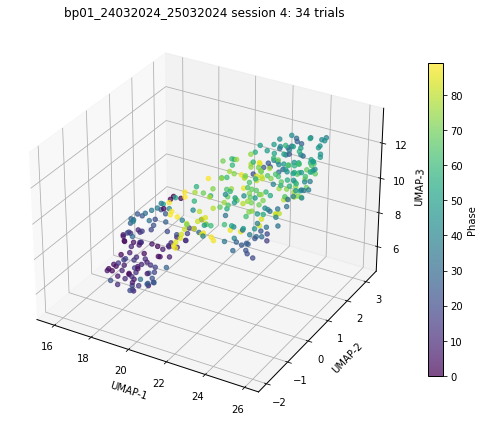

UMAP embedding shape: (360, 3)


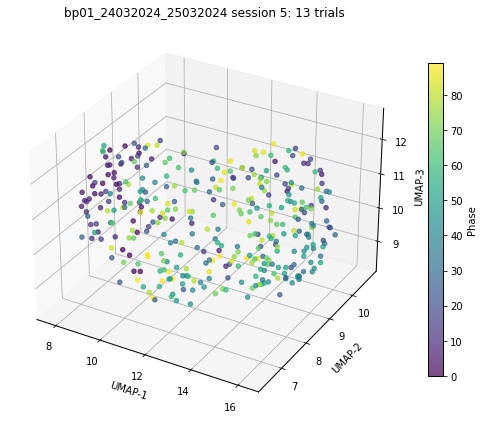

KeyboardInterrupt: 

In [ ]:

for mouse_recday in mouse_recdays:
    for session in valid_sessions_dic[mouse_recday]:
        num_trials = data_dic[mouse_recday][session]['num_trials']
        all_neurons_concat = data_dic[mouse_recday][session]['Mean_norm']
        sig_neurons = sig_neurons_dic[mouse_recday]
        all_neurons_concat[sig_neurons, :]
        labels = list(range(90))*4
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(all_neurons_concat.T)

        # -------------------------
        # UMAP Dimensionality Reduction
        # -------------------------
        # We set n_components=3 to get a 3D embedding.
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
        X_embedding = reducer.fit_transform(X_scaled)

        # X_embedding will now be of shape (n_samples, 3)
        print("UMAP embedding shape:", X_embedding.shape)

        # -------------------------
        # Visualization
        # -------------------------
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot: we color points by their condition/label
        scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                            c=labels, cmap='viridis', alpha=0.7)

        ax.set_title(f'{mouse_recday} session {session} {num_trials} trials')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
        ax.set_zlabel('UMAP-3')

        # Optionally add a legend or colorbar
        cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
        cbar.set_label('Phase')

        plt.tight_layout()
        plt.show()

In [185]:
valid_sessions_dic[mouse_recday]

KeyError: 'b'

In [199]:
total_cells = 0
for mouse_recday in mouse_recdays:
    total_cells += len(sig_neurons_dic[mouse_recday])

In [200]:
total_cells

113

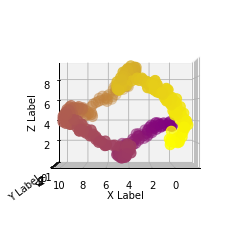

In [229]:
##UMAP embedding
import matplotlib as mpl
%matplotlib inline

def colorFader(c1_,c2_,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1_))
    c2=np.array(mpl.colors.to_rgb(c2_))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


all_neurons_concat = []
for mouse_recday in mouse_recdays:
    for session in valid_sessions_dic[mouse_recday]:
        sig_neurons = sig_neurons_dic[mouse_recday]
        xxx = data_dic[mouse_recday][session]['Mean_norm']
        all_neurons_concat.append(xxx[sig_neurons,:])
all_neuron_sessions  = np.vstack((all_neurons_concat))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neuron_sessions.T)

reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
embedding_mean_pertask = reducer.fit_transform(X_scaled)

c1_='yellow'
c2_='purple' 
n=len(embedding_mean_pertask)

colors_state=[]
for x in np.arange(n):
    colors_state.append(colorFader(c1_,c2_,x/n))

    
c1_='lightgreen'
c2_='black' 
colors_phase=[]
num_states=(n/90)
for state in np.arange(num_states):
    for x in np.arange(90):
        colors_phase.append(colorFader(c1_,c2_,x/90))

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#embedding_mean=np.load(Input_folder+'Embedding_example_ABCD_08042024_1321.npy')

x = embedding_mean_pertask[:,0]
y = embedding_mean_pertask[:,1]
z = embedding_mean_pertask[:,2]

ax.scatter(x, y, z, c=colors_state, marker='o',s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.azim = 90 ## rotate around z axis
ax.elev = 0 ##angle between eye and xy plane (i.e. 0 = looking from side, 90= looking from top)
# plt.savefig(Output_folder+'UMAP_withintask_state.svg',\
#                 bbox_inches = 'tight', pad_inches = 0)
plt.show()

UMAP embedding shape: (360, 3)


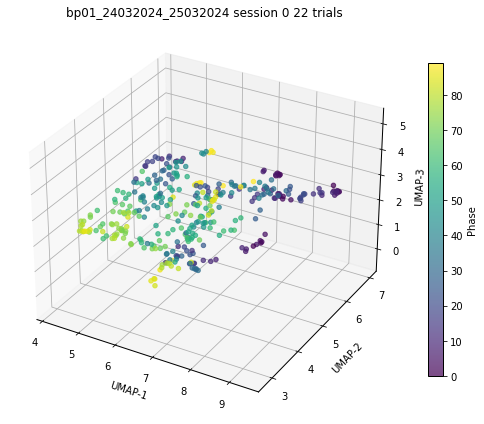

UMAP embedding shape: (360, 3)


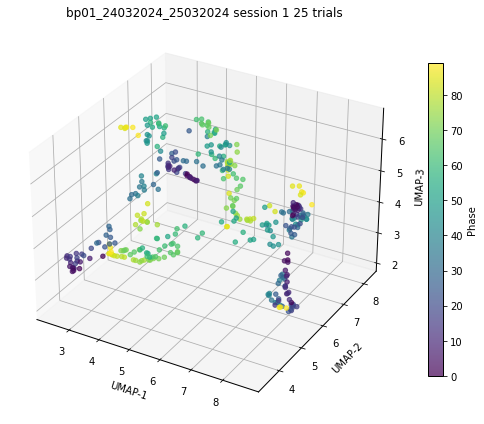

UMAP embedding shape: (360, 3)


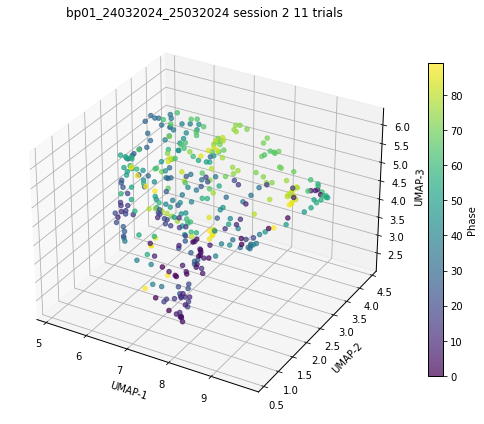

UMAP embedding shape: (360, 3)


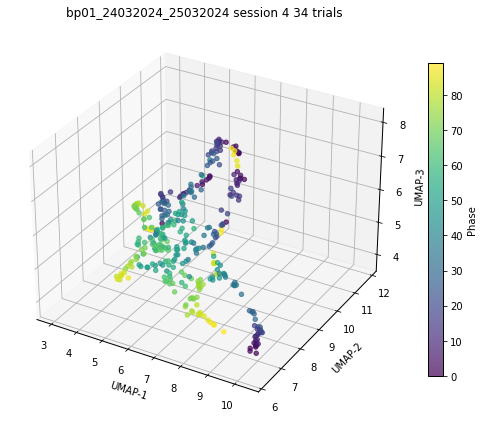

UMAP embedding shape: (360, 3)


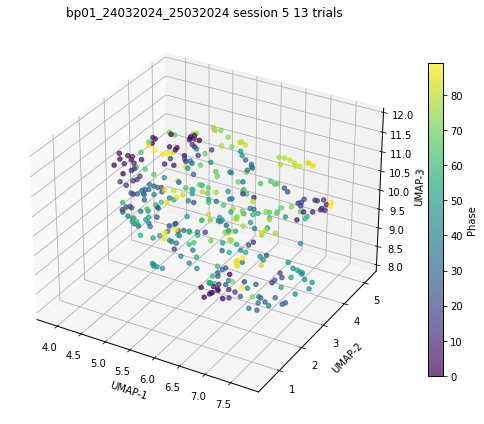

UMAP embedding shape: (360, 3)


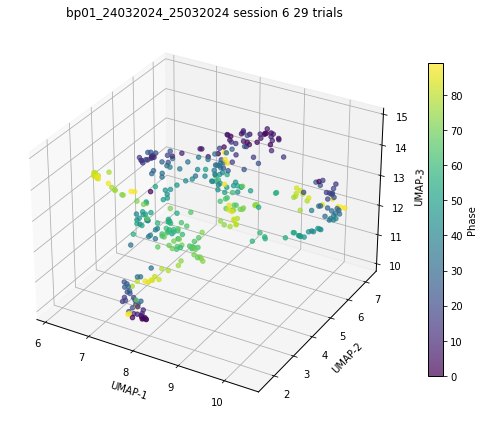

UMAP embedding shape: (360, 3)


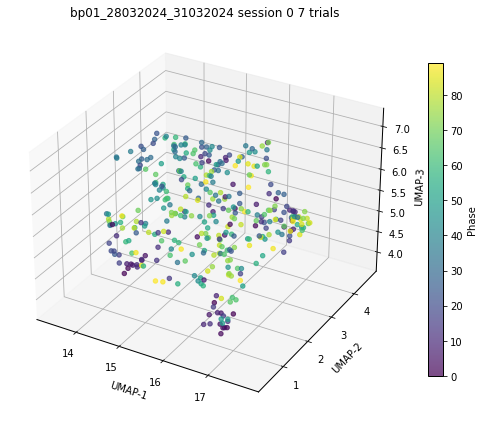

UMAP embedding shape: (360, 3)


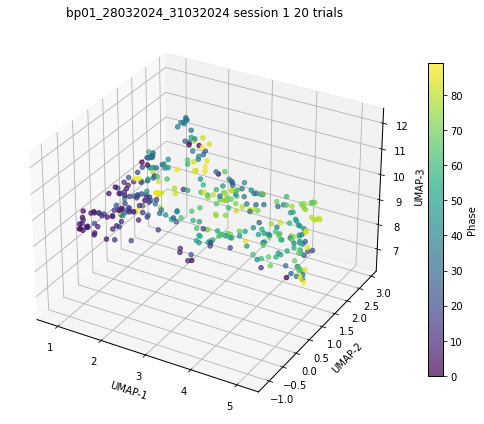

UMAP embedding shape: (360, 3)


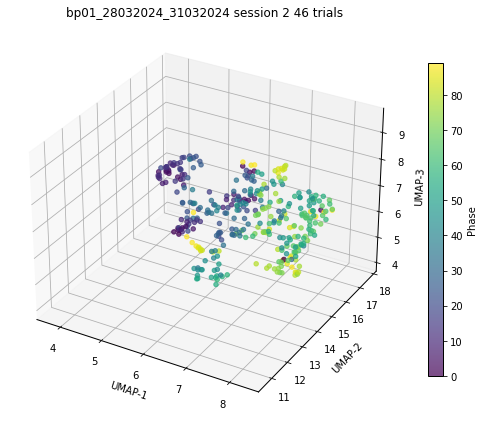

UMAP embedding shape: (360, 3)


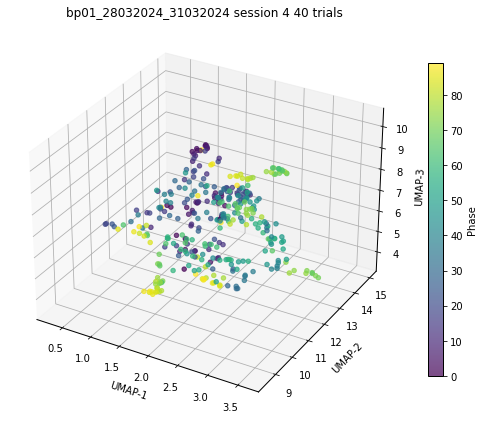

UMAP embedding shape: (360, 3)


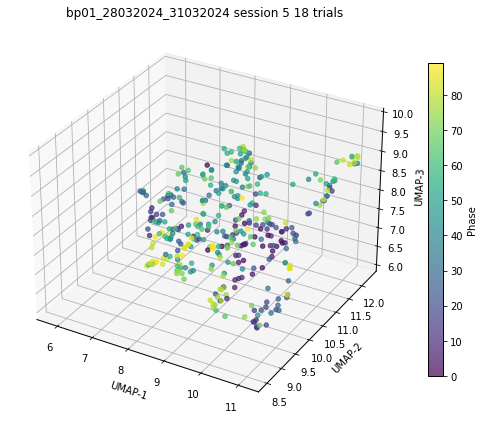

UMAP embedding shape: (360, 3)


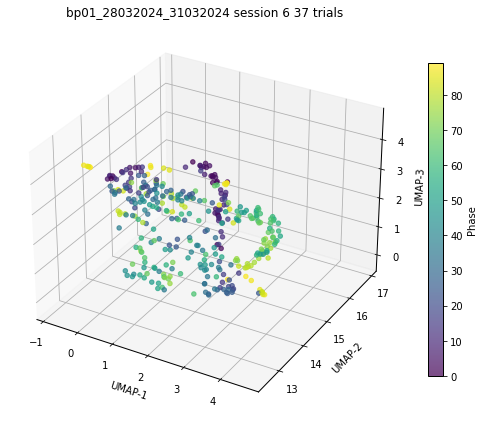

UMAP embedding shape: (360, 3)


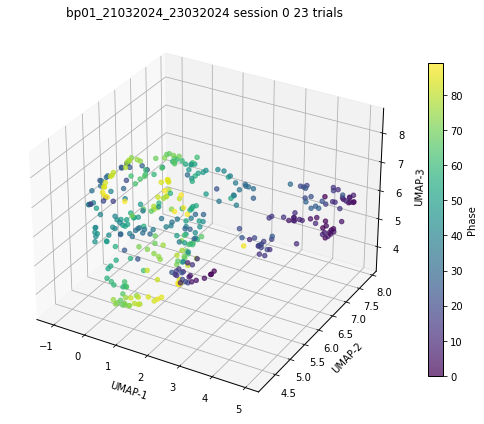

UMAP embedding shape: (360, 3)


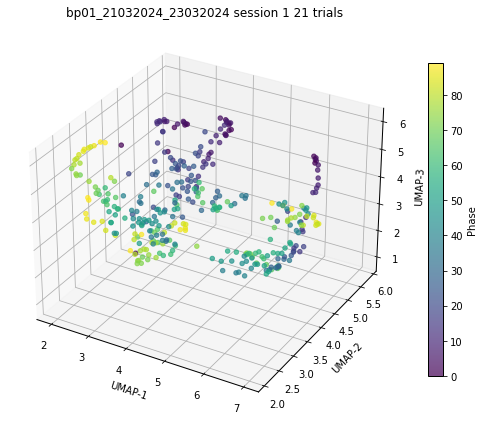

UMAP embedding shape: (360, 3)


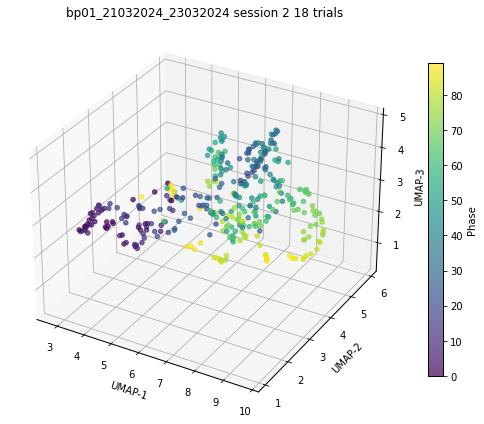

UMAP embedding shape: (360, 3)


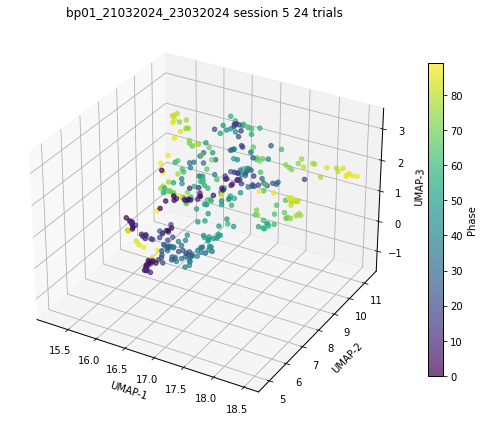

UMAP embedding shape: (360, 3)


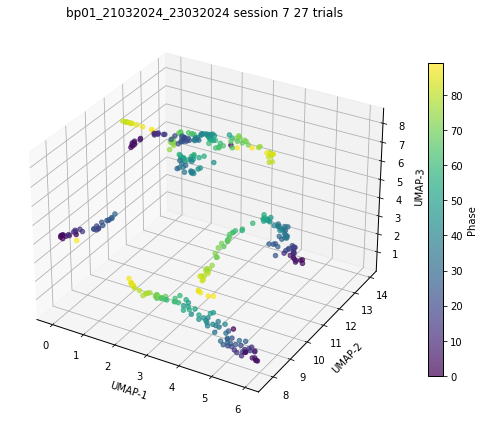

UMAP embedding shape: (360, 3)


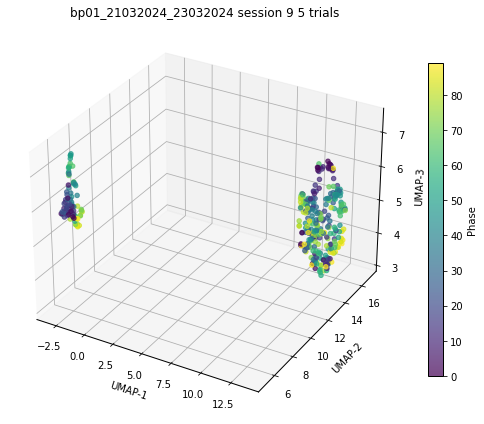

UMAP embedding shape: (360, 3)


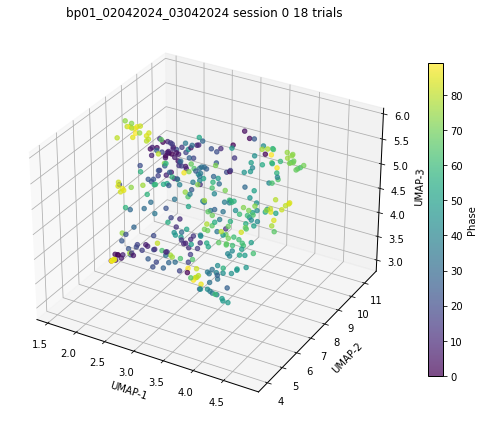

UMAP embedding shape: (360, 3)


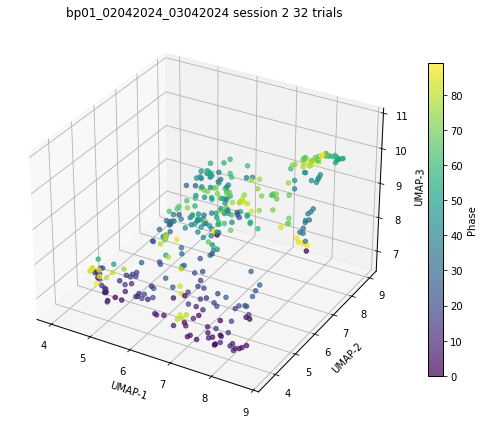

UMAP embedding shape: (360, 3)


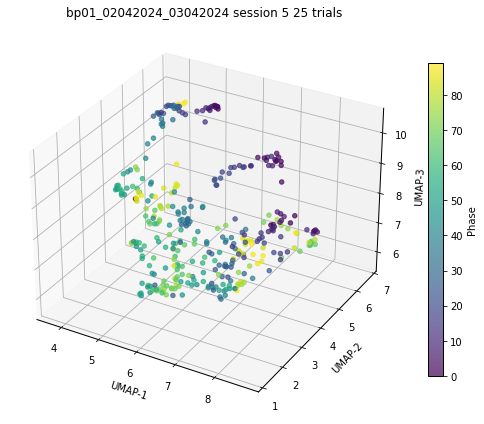

UMAP embedding shape: (360, 3)


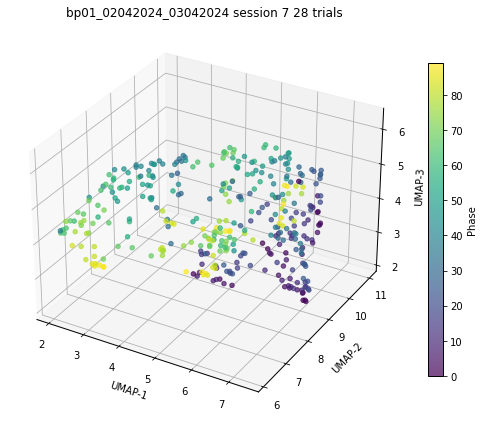

In [ ]:
for mouse_recday in mouse_recdays:
    for session in valid_sessions_dic[mouse_recday]:
        num_trials = data_dic[mouse_recday][session]['num_trials']
        neurons_ = data_dic[mouse_recday][session]['Mean_norm']
        sig_neurons = sig_neurons_dic[mouse_recday]
        sig_neurons_data = neurons_[sig_neurons, :]
        labels = list(range(90))*4
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(sig_neurons_data.T)

        # -------------------------
        # UMAP Dimensionality Reduction
        # -------------------------
        # We set n_components=3 to get a 3D embedding.
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
        X_embedding = reducer.fit_transform(X_scaled)

        # X_embedding will now be of shape (n_samples, 3)
        print("UMAP embedding shape:", X_embedding.shape)

        # -------------------------
        # Visualization
        # -------------------------
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot: we color points by their condition/label
        scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                            c=labels, cmap='viridis', alpha=0.7)

        ax.set_title(f'{mouse_recday} session {session} {num_trials} trials')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
        ax.set_zlabel('UMAP-3')

        # Optionally add a legend or colorbar
        cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
        cbar.set_label('Phase')

        plt.tight_layout()
        plt.show()

In [237]:
total_cells = 0
for mouse_recday in mouse_recdays:
    first_session = valid_sessions_dic[mouse_recday][0]
    total_cells += data_dic[mouse_recday][first_session]['num_neurons']

In [245]:
def mean_list_of_2d_arrays(list_of_2d_arrays):
    """
    Compute the element-wise mean of a list of 2D arrays, each of shape (n, m).
    
    Parameters
    ----------
    list_of_2d_arrays : list of numpy.ndarray
        A list where each element is a 2D NumPy array of equal shape (n, m).
        
    Returns
    -------
    numpy.ndarray
        A single 2D NumPy array of shape (n, m) that is the element-wise mean 
        of all the arrays in the input list.
    """
    
    # Stack all arrays to form a 3D array of shape (k, n, m),
    # where k is the number of arrays in the list.
    stacked = np.stack(list_of_2d_arrays, axis=0)
    
    # Compute the mean along the first axis (axis=0),
    # which averages over the list dimension, leaving a (n, m) array.
    mean_array = np.mean(stacked, axis=0)
    
    return mean_array

In [262]:
all_neurons_concat = []
for mouse_recday in mouse_recdays:
    recday_neurons = []
    for session in valid_sessions_dic[mouse_recday]:
        sig_neurons = sig_neurons_dic[mouse_recday]
        xxx = data_dic[mouse_recday][session]['Mean_norm']
        recday_neurons.append(xxx[sig_neurons,:])
    all_neurons_concat.append(mean_list_of_2d_arrays(recday_neurons))
print(len(all_neurons_concat))
all_neurons_concat = np.vstack((all_neurons_concat))
print(all_neurons_concat.shape)

4
(113, 360)


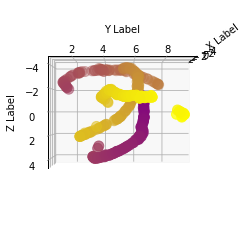

In [260]:
##UMAP embedding
import matplotlib as mpl
%matplotlib inline

def colorFader(c1_,c2_,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1_))
    c2=np.array(mpl.colors.to_rgb(c2_))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

# reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
# embedding_mean_pertask = reducer.fit_transform(X_scaled)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
embedding_mean_pertask = reducer.fit_transform(X_scaled)

c1_='yellow'
c2_='purple' 
n=len(embedding_mean_pertask)

colors_state=[]
for x in np.arange(n):
    colors_state.append(colorFader(c1_,c2_,x/n))

    
c1_='lightgreen'
c2_='black' 
colors_phase=[]
num_states=(n/90)
for state in np.arange(num_states):
    for x in np.arange(90):
        colors_phase.append(colorFader(c1_,c2_,x/90))

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#embedding_mean=np.load(Input_folder+'Embedding_example_ABCD_08042024_1321.npy')

x = embedding_mean_pertask[:,0]
y = embedding_mean_pertask[:,1]
z = embedding_mean_pertask[:,2]

ax.scatter(x, y, z, c=colors_state, marker='o',s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.azim = 0 ## rotate around z axis
ax.elev = 180 ##angle between eye and xy plane (i.e. 0 = looking from side, 90= looking from top)
# plt.savefig(Output_folder+'UMAP_withintask_state.svg',\
#                 bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Stability across sessions

In [ ]:
def circular_smooth(data, sigma=5):
    """
    Smooths a 1D array while respecting its circularity.

    Parameters:
    - data: np.ndarray
        The input array of shape (timepoints,).
    - sigma: float
        The standard deviation for Gaussian smoothing.

    Returns:
    - smoothed_data: np.ndarray
        The smoothed array of the same length as the input.
    """
    extended_data = np.concatenate([data, data, data])
    smoothed_extended = gaussian_filter1d(extended_data, sigma=sigma)
    original_length = len(data)
    smoothed_data = smoothed_extended[original_length:2 * original_length]
    return smoothed_data

# Example input: List of 3D arrays [neurons x trials x timepoints]
data = norm_neurons_list  # Replace with your actual list of 3D arrays
num_sessions = len(data)
sigma = 5  # Smoothing parameter

# Step 1: Calculate mean firing rate across trials for each timepoint
mean_across_trials = [np.mean(session, axis=1) for session in data]  # List of [neurons x timepoints]

# Step 2: Z-score each neuron's firing rate within its session
z_scored_data = [((session - np.mean(session, axis=1, keepdims=True)) /
                  np.std(session, axis=1, keepdims=True)) for session in mean_across_trials]

# Step 3: Apply circular smoothing to z-scored data
smoothed_data = [np.array([circular_smooth(neuron_data, sigma=sigma) for neuron_data in session])
                 for session in z_scored_data]

# Step 4: Reshape into task-state averages (neurons x 90)
task_state_averages = [np.mean(session.reshape(session.shape[0], 4, 90), axis=1) for session in smoothed_data]

# Step 5: Sort neurons in the first session by peak firing rate
first_session = task_state_averages[0]
peak_values = np.max(first_session, axis=1)  # Peak firing rate for each neuron
peak_indices = np.argmax(first_session, axis=1)  # Index of peak for each neuron

# Sort by peak value, breaking ties with the peak index
sorting_order = np.lexsort((-peak_values, peak_indices))  # Sort by peak value (descending), then index
print(sorting_order)
# Apply sorting to all sessions
sorted_task_state_averages = [session[sorting_order] for session in task_state_averages]

# Debugging: Check if sorting is consistent
sorted_first_session = sorted_task_state_averages[0]
# assert np.all(np.diff(np.max(sorted_first_session, axis=1)) <= 0), "Sorting failed: Peaks are not descending."

# Step 6: Plot using Seaborn
fig, axes = plt.subplots(1, num_sessions-1, figsize=(15, 6), sharey=True)

for i, session in enumerate(sorted_task_state_averages[:-1]):
    ax = axes[i]
    sns.heatmap(
        session,
        cmap="coolwarm",
        ax=ax,
        cbar=i == num_sessions - 1,  # Show colorbar only on the last plot
        xticklabels=range(1, 91),
        yticklabels=False,
    )
    ax.set_title(f"Session {i + 1}")
    ax.set_xlabel("Task State Timepoints")
    if i == 0:
        ax.set_ylabel("Neurons (Sorted by Session 1)")

plt.tight_layout()
plt.show()



# Looking at simulated neurons with only spatial tuning

In [63]:
sims_path = 'spatial_sims/sim_data/simulation_data.pkl'
with open(sims_path,'rb') as f:
    sims_data = pickle.load(f)


In [64]:
sims_data['sessions'][0]['trials_data'][0]['spikes']

array([[ 0,  1,  2, ...,  2,  3,  1],
       [ 1,  3,  1, ...,  2,  2,  1],
       [ 0,  2,  0, ...,  3,  2,  1],
       ...,
       [ 9,  3,  8, ...,  5, 15,  6],
       [ 0,  0,  1, ...,  1,  0,  1],
       [ 0,  1,  1, ...,  0,  1,  0]])

In [65]:
positions = sims_data['sessions'][0]['trials_data'][0]['positions_timebins']
filtered_positions = [positions[i] for i in range(len(positions)) if i == 0 or positions[i] != positions[i - 1]]

print(filtered_positions)

[2, 5, 6, 9, 8, 7, 4, 1, 2]


In [66]:
# for i in range(50):
#     plt.plot(smooth_circ(sims_data['sessions'][0]['trials_data'][0]['spikes'][i]))
#     plt.show()  

In [67]:
def compute_mean_firing(sim_data):
    n_sessions = sim_data["n_sessions"]
    n_trials = sim_data["n_trials"]
    n_neurons = sim_data["n_neurons"]

    mean_rates_list = []
    T = None

    for s_idx in range(n_sessions):
        session_dict = sim_data["sessions"][s_idx]
        trials_data = session_dict["trials_data"]
        
        if T is None:
            T = trials_data[0]["spikes"].shape[1]  # e.g. 360

        all_spikes = np.zeros((n_trials, n_neurons, T), dtype=float)
        for t_idx in range(n_trials):
            all_spikes[t_idx, :, :] = trials_data[t_idx]["spikes"]

        # Mean across trials -> shape (n_neurons, T)
        session_mean = all_spikes.mean(axis=0)
        mean_rates_list.append(session_mean)

    # shape: (n_sessions, n_neurons, T)
    mean_rates = np.stack(mean_rates_list, axis=0)
    return mean_rates

mean_rates = compute_mean_firing(sims_data)

###################
# 3) CIRCULAR SMOOTHING
###################
def circular_smooth_1d(data_1d, window_size=5):
    T = len(data_1d)
    triple = np.concatenate([data_1d, data_1d, data_1d])
    kernel = np.ones(window_size) / window_size
    convolved = np.convolve(triple, kernel, mode='same')
    start = T
    end = 2*T
    smoothed = convolved[start:end]
    return smoothed

def smooth_mean_firing(mean_rates, window_size=5):
    n_sessions, n_neurons, T = mean_rates.shape
    smoothed_rates = np.zeros_like(mean_rates)

    for s_idx in range(n_sessions):
        for n_idx in range(n_neurons):
            fr_1d = mean_rates[s_idx, n_idx, :]
            fr_1d_smooth = circular_smooth_1d(fr_1d, window_size=window_size)
            smoothed_rates[s_idx, n_idx, :] = fr_1d_smooth

    return smoothed_rates

window_size = 5  # or pick another size
smoothed_rates = smooth_mean_firing(mean_rates, window_size)

###################
# 4) OPTIONAL: SAVE
###################

In [68]:
smoothed_rates.shape

(5, 200, 360)

UMAP embedding shape: (360, 3)


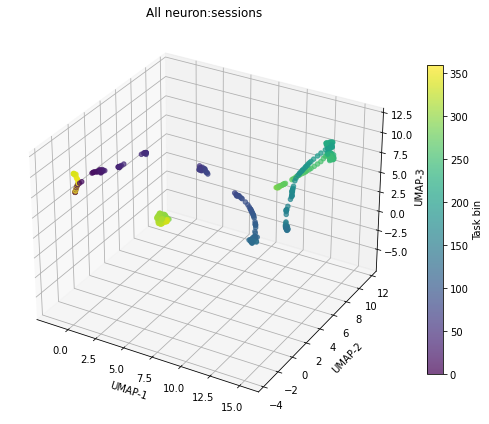

In [69]:
# -------------------------
# Preprocessing (Optional)
# -------------------------
# Standard scaling the data so that each feature (neuron) has zero mean and unit variance.

from mpl_toolkits.mplot3d import Axes3D  # Just to be explicit, though in newer Matplotlib versions not always needed
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

all_neurons_concat = []
for session in smoothed_rates:
    
    all_neurons_concat.append(session)
all_neurons_concat = np.vstack((all_neurons_concat))


labels = list(range(360))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

# -------------------------
# UMAP Dimensionality Reduction
# -------------------------
# We set n_components=3 to get a 3D embedding.

#MY PARAMS
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_embedding = reducer.fit_transform(X_scaled)


# YOUR PARAMS (plus random state for reproducability)
# reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
# X_embedding = reducer.fit_transform(X_scaled)




# X_embedding will now be of shape (n_samples, 3)
print("UMAP embedding shape:", X_embedding.shape)

# -------------------------
# Visualization
# -------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: we color points by their condition/label
scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                     c=labels, cmap='viridis', alpha=0.7)

ax.set_title('All neuron:sessions')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')

# Optionally add a legend or colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
cbar.set_label('Task bin')

plt.tight_layout()
plt.show()

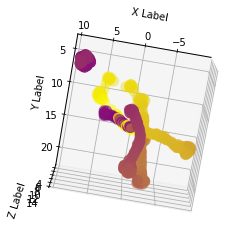

In [70]:
##UMAP embedding
import matplotlib as mpl
%matplotlib inline

def colorFader(c1_,c2_,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1_))
    c2=np.array(mpl.colors.to_rgb(c2_))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
embedding_mean_pertask = reducer.fit_transform(X_scaled)

c1_='yellow'
c2_='purple' 
n=len(embedding_mean_pertask)

colors_state=[]
for x in np.arange(n):
    colors_state.append(colorFader(c1_,c2_,x/n))

    
c1_='lightgreen'
c2_='black' 
colors_phase=[]
num_states=(n/90)
for state in np.arange(num_states):
    for x in np.arange(90):
        colors_phase.append(colorFader(c1_,c2_,x/90))

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#embedding_mean=np.load(Input_folder+'Embedding_example_ABCD_08042024_1321.npy')

x = embedding_mean_pertask[:,0]
y = embedding_mean_pertask[:,1]
z = embedding_mean_pertask[:,2]

ax.scatter(x, y, z, c=colors_state, marker='o',s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.azim = 100 ## rotate around z axis
ax.elev = 100 ##angle between eye and xy plane (i.e. 0 = looking from side, 90= looking from top)
# plt.savefig(Output_folder+'UMAP_withintask_state.svg',\
#                 bbox_inches = 'tight', pad_inches = 0)
plt.show()

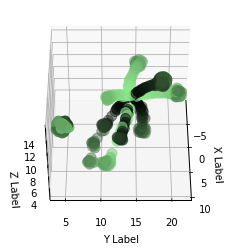

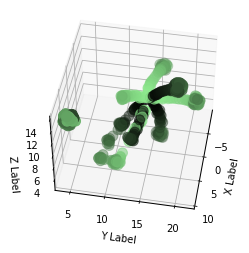

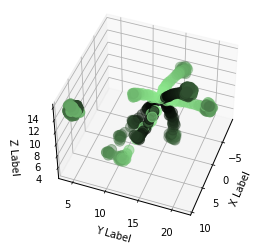

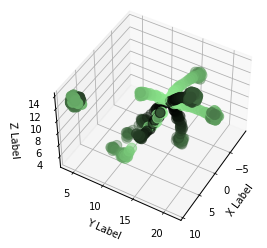

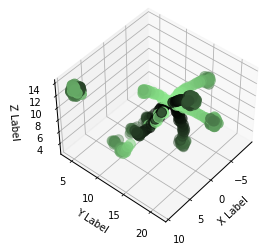

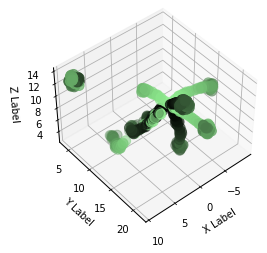

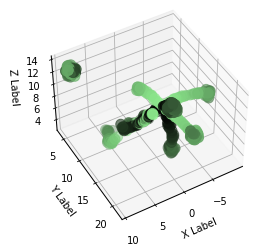

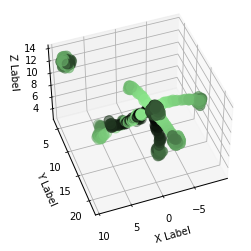

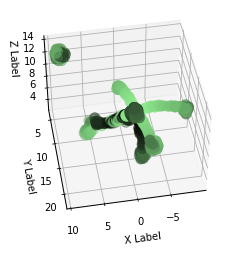

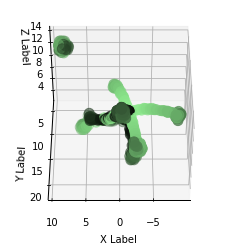

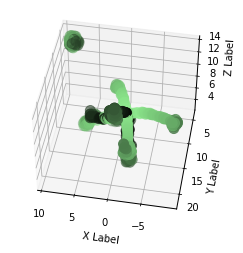

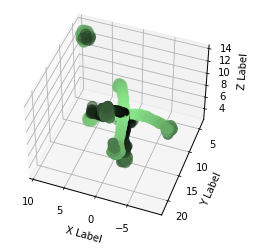

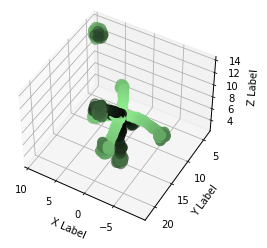

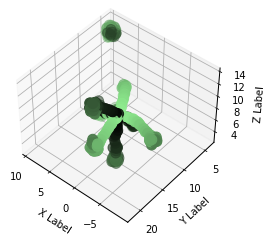

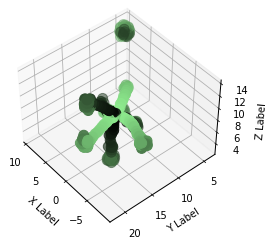

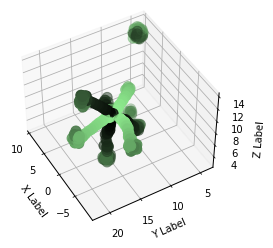

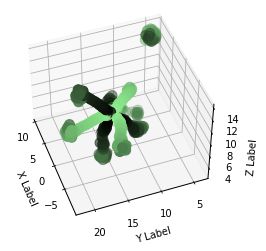

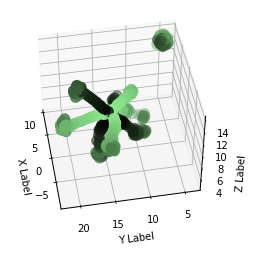

In [71]:
for azim in range(0, 180, 10):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #embedding_mean=np.load(Input_folder+'Embedding_example_ABCD_08042024_1321.npy')

    x = embedding_mean_pertask[:,0]
    y = embedding_mean_pertask[:,1]
    z = embedding_mean_pertask[:,2]

    ax.scatter(x, y, z, c=colors_phase, marker='o',s=100)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax.azim = azim ## rotate around z axis
    ax.elev = 45 ##angle between eye and xy plane (i.e. 0 = looking from side, 90= looking from top)
    # plt.savefig(Output_folder+'UMAP_withintask_state.svg',\
    #                 bbox_inches = 'tight', pad_inches = 0)
    plt.show()

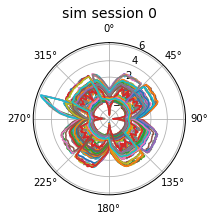

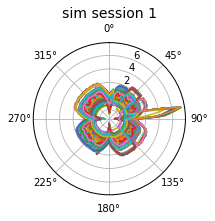

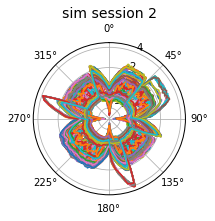

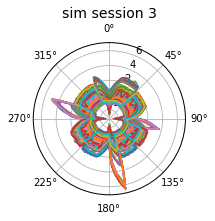

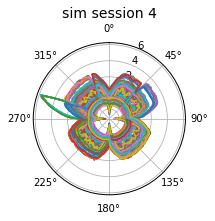

In [77]:
for session, array in enumerate(smoothed_rates):
                        
    ax1 = plt.subplot(121, projection="polar")

    for neuron in range(array.shape[0]):
        n = zscore(array[neuron,:])
        ax1.plot(angles, n)

    ax1.set_title(f"sim session {session}", fontsize=14)
    ax1.set_theta_zero_location("N")
    ax1.set_theta_direction(-1)
    plt.show()

In [82]:
angle_shifts_sim = []
angle_1s_sim = []
angle_2s_sim = []

for session1, array1 in tqdm(enumerate(smoothed_rates[:-1])):
    for session2, array2 in enumerate(smoothed_rates[session1+1:]):
        for neuron1 in range(array1.shape[0]-1):
            for neuron2 in range(1, array1.shape[0]):         
                # Get firing rates for these two neurons in session X
                mean1 = array1[neuron1,:]
                mean1 = mean1-np.mean(mean1)
                mean2 = array1[neuron2,:]
                mean2 = mean2-np.mean(mean2)
                angle1 = compute_remapping_angle(mean1, mean2)
                angle_1s_sim.append(angle1)

                mean1 = array2[neuron1,:]
                mean1 = mean1-np.mean(mean1)
                mean2 = array2[neuron2,:]
                mean2 = mean2-np.mean(mean2)   
                angle2 = compute_remapping_angle(mean1, mean2)
                angle_2s_sim.append(angle2)
                # Compute the difference in their angles between sessions
                angle_diff = (angle1 - angle2) % 360
                # angle_diff = (angle_diff + 180) % 360 - 180

    
                angle_shifts_sim.append(angle_diff)
         

0it [00:00, ?it/s]

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_1s_sim), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$sim neuronx - neurony$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_shifts_sim), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'sim $\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)